# Manual Testing

This file is designed to load in the saved models trained by main.py and evaluate them

In [1]:
import sys
sys.path.append('..')
from a2c_ppo_acktr import algo, utils
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from evaluation import evaluate
from tqdm import tqdm

import matplotlib.pyplot as plt

def load_model(algo='ppo', env=None, filename=None):
    '''
    Load a trained model from the algorithm
    '''
    if env is None and filename is None:
        raise
    file = 'trained_models/' + algo + '/'
    if env is not None:
        file = file + env + '.pt'
    elif filename is not None:
        file = file + filename
        
    model, rms = torch.load(file)

    return model, rms
    
import math
import matplotlib.pyplot as plt
import proplot as pplt

def draw_character(pos, angle, size=10, ax=None, draw_color=[0.9, 0.9, 0, 0.3]):
    angle1 = angle - 0.3
    angle2 = angle + 0.3
    point1 = [pos[0], pos[1]]
    point2 = [pos[0] - math.cos(angle1)*size, pos[1] - math.sin(angle1)*size]
    point3 = [pos[0] - math.cos(angle2)*size, pos[1] - math.sin(angle2)*size]

    poly = plt.Polygon([point1, point2, point3], fc=draw_color)

    if ax == None:
        plt.gca().add_patch(poly)
    else:
        ax.add_patch(poly)

    
%run model_evaluation
%run representation_analysis

# Test running a single model and running Policy, FlexBase

In [ ]:
%run model_evaluation

model, obs_rms, kwargs = load_model_and_env('nav_auxiliary_tasks/nav_c4_auxwall1', 0)

action_randomizer = lambda step: np.random.choice([0, 1, 2])
results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                data_callback=nav_data_callback, num_episodes=1, with_activations=True)


obs, rnn_hxs, masks = results['obs'][0], results['hidden_states'][0], results['masks'][0]

import sys
sys.path.append('../')
from a2c_ppo_acktr.model import Policy

env = gym.make('NavEnv-v0', **kwargs)

model = Policy(obs.squeeze().shape, env.action_space, base='FlexBase', base_kwargs={'num_shared_layers': 0, 'auxiliary_heads': [[-1, 0, 1]]})
# model = Policy(obs.squeeze().shape, env.action_space, base='FlexBase', base_kwargs={'num_shared_layers': 0})

# model, obs_rms, kwargs = load_model_and_env('nav_invisible_shared/nav_c4_shared0.dist', 0)
action_randomizer = lambda step: np.random.choice([0, 1, 2])
results = forced_action_evaluate(model, obs_rms, forced_actions=action_randomizer, env_kwargs=kwargs, 
                                data_callback=nav_data_callback, num_episodes=1, with_activations=True)


In [6]:
model, obs_rms, kwargs = load_model_and_env('nav_auxiliary_tasks2/nav_c4_auxeuclid0', 0)
env = gym.make('NavEnv-v0', **kwargs)

In [18]:
def quick_vec_env(obs_rms, env_kwargs={}, env_name='NavEnv-v0', seed=0,
                 num_processes=1, eval_log_dir='/tmp/gym/_eval',
                 device=torch.device('cpu'), capture_video=False):
    eval_envs = make_vec_envs(env_name, seed + num_processes, num_processes,
                          None, eval_log_dir, device, True, 
                          capture_video=capture_video, 
                          env_kwargs=env_kwargs)

    vec_norm = utils.get_vec_normalize(eval_envs)
    if vec_norm is not None:
        vec_norm.eval()
        vec_norm.obs_rms = obs_rms
        
    return eval_envs


**Test making vec_envs and policy**

In [71]:
kwargs = {
    'task_structure': 4,
    'rew_structure': 'goal',
    'num_objects': 0,
    'wall_colors': 1,
    'poster': 1,
    'num_rays': 12,
    'fov': 1
}

env_kwargs = {'num_objects': 0, 'rew_structure': 'goal',
              'task_structure': 4, 'wall_colors': 1, 'num_rays': 12, 'fov': 1,
              'poster': 1, #distal
              'character_reset_pos': 1}
# env = gym.make('NavEnv-v0', **kwargs)
envs = make_vec_envs('NavEnv-v0', 0, 1, 0.99, '/tmp/gym/', torch.device('cpu'),
                     False, capture_video=False, env_kwargs=env_kwargs)
model = Policy(envs.observation_space.shape, envs.action_space, 
               base='FlexBase', base_kwargs={'hidden_size': 4})

obs = envs.reset()
rnn_hxs = torch.zeros(model.recurrent_hidden_state_size).view(1, -1)
masks = torch.ones([1, 1])

# model.base(obs, rnn_hxs, masks)
model.act(obs, rnn_hxs, masks)

{'value': tensor([[-0.0015]], grad_fn=<AddmmBackward0>),
 'actor_features': tensor([[ 0.0005,  0.0024,  0.0019, -0.0011]], grad_fn=<TanhBackward0>),
 'rnn_hxs': tensor([[ 0.0007, -0.0013,  0.0007,  0.0003]], grad_fn=<SqueezeBackward1>),
 'auxiliary_preds': tensor([[0.]]),
 'action': tensor([[1]]),
 'action_log_probs': tensor([[-1.3863]], grad_fn=<UnsqueezeBackward0>)}

In [72]:
model.evaluate_actions(obs, rnn_hxs, masks, torch.tensor([[1]]))

(tensor([[-0.0015]], grad_fn=<AddmmBackward0>),
 tensor([[-1.3863]], grad_fn=<UnsqueezeBackward0>),
 tensor(1.3863, grad_fn=<MeanBackward0>),
 tensor([[ 0.0007, -0.0013,  0.0007,  0.0003]], grad_fn=<SqueezeBackward1>),
 tensor([[0.]]))

## Example: Test Correlated 2-arm Bandits

In [2]:
# env_name = 'CartPole-v1'
env_name = 'Bandits-v0'
model, rms = load_model(env=env_name, algo='a2c')
log_dir = '/tmp/gym/_eval'
device = torch.device("cpu")


In [3]:
all_obs, all_actions, all_rewards, all_hidden_states, eval_envs = evaluate(model, rms, env_name, 1, 10, log_dir, device)

 Evaluation using 10 episodes: mean reward 77.30000



In [4]:
all_obs2 = torch.zeros(size=[len(all_obs)] + list(all_obs[0].shape))
all_actions2 = torch.zeros(size=[len(all_actions)] + list(all_actions[0].shape))
all_rewards2 = torch.zeros(size=[len(all_rewards)] + list(all_rewards[0].shape))
all_hidden_states2 = torch.zeros(size=[len(all_hidden_states)] + list(all_hidden_states[0].shape))

for i in range(len(all_obs)):
    all_obs2[i] = all_obs[i]
    all_actions2[i] = all_actions[i]
    all_rewards2[i] = all_rewards[i]
    all_hidden_states2[i] = all_hidden_states[i]

In [7]:
reward_probabilities = eval_envs.get_attr('reward_probabilities')

In [19]:
second_arm_probs = []
second_arm_choices = []
for i in range(all_actions2.shape[1]):
    second_arm_choices.append(torch.mean(all_actions2.T[0][i]))
    second_arm_probs.append(reward_probabilities[i][1])

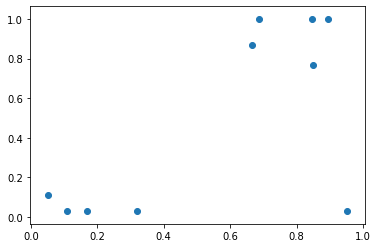

In [21]:
plt.scatter(second_arm_probs, second_arm_choices)

## Test Goal Dist Auxiliary Task

In [1]:
%run representation_analysis
%run model_evaluation

In [4]:

env_kwargs = {'num_objects': 0, 'rew_structure': 'goal',
              'task_structure': 2, 'wall_colors': 1, 'num_rays': 12, 'fov': 1,
              'poster': 1, 'auxiliary_tasks': [3, 2], 'auxiliary_task_args': [None, 3],
              'character_reset_pos': 1}
# env = gym.make('NavEnv-v0', **kwargs)
envs = make_vec_envs('NavEnv-v0', 0, 1, 0.99, '/tmp/gym/', torch.device('cpu'),
                     False, capture_video=False, env_kwargs=env_kwargs)
model = Policy(envs.observation_space.shape, envs.action_space, 
               base='FlexBase', base_kwargs={'hidden_size': 4, 'auxiliary_heads': [[-1, 0, 1]]})

obs = envs.reset()
rnn_hxs = torch.zeros(model.recurrent_hidden_state_size).view(1, -1)
masks = torch.ones([1, 1])

# model.base(obs, rnn_hxs, masks)
model.act(obs, rnn_hxs, masks)
envs.step(torch.tensor([[1]]))

(tensor([[ 0.0012,  0.0012,  0.0012,  0.0012,  0.0012,  0.0012,  0.0012,  0.0012,
           0.0012,  0.0012,  0.0012,  0.0012, -0.7812, -0.7854, -0.7913, -0.7990,
          -0.8084, -0.8194, -0.8318, -0.8455, -0.8601, -0.8753, -0.7181, -0.7047]]),
 tensor([[0.]]),
 array([False]),
 [{'auxiliary': array([0.39090402, 0.29447325])}])

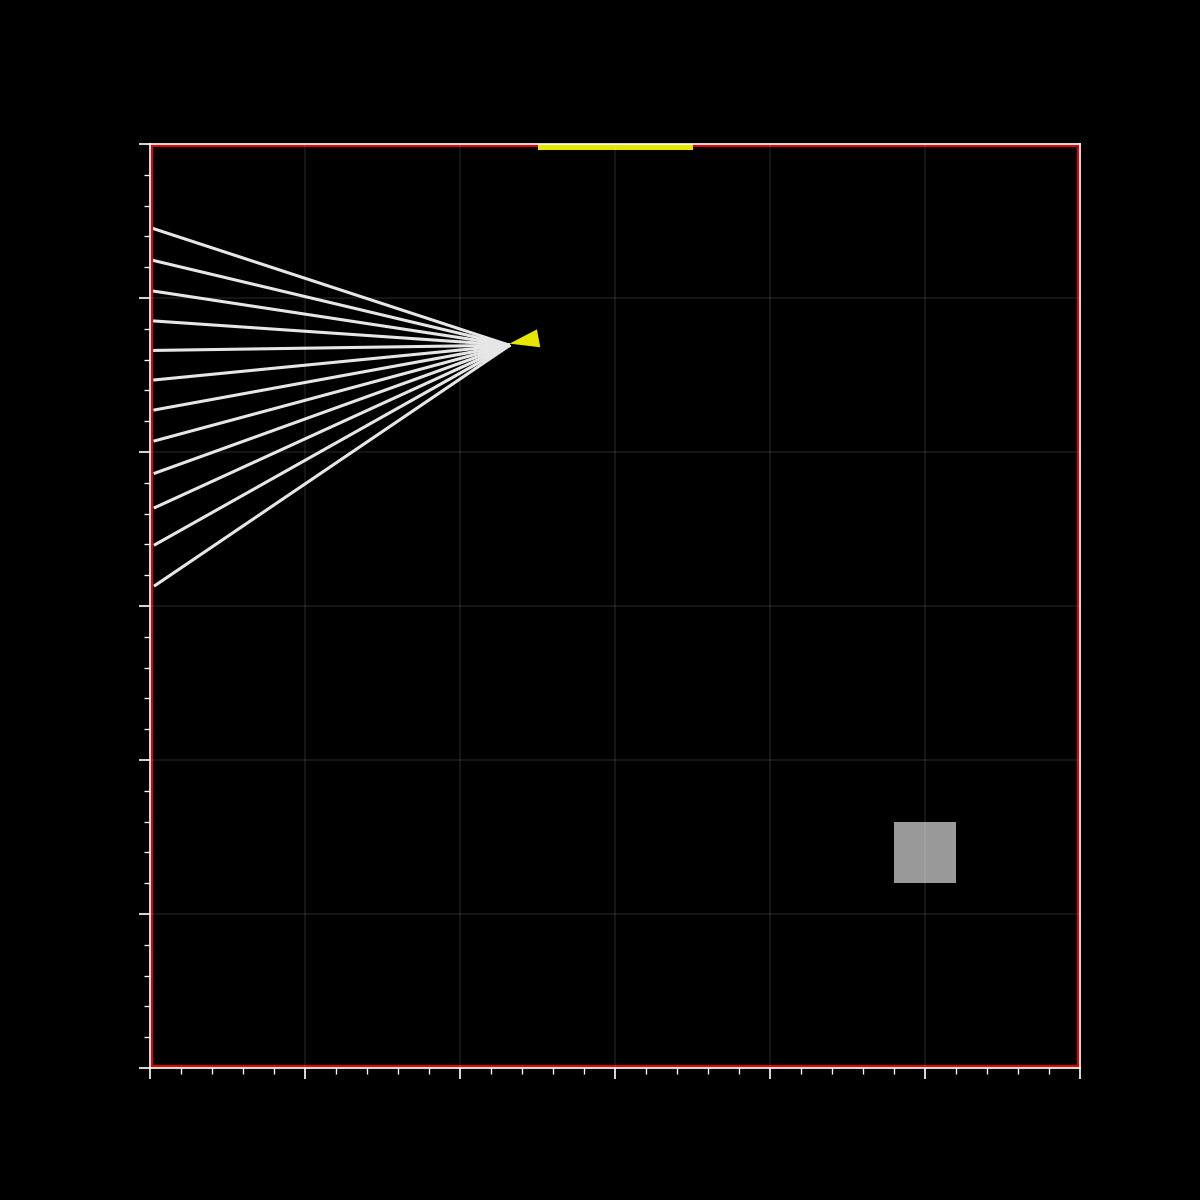

In [7]:
env = gym.make('NavEnv-v0', **env_kwargs)
env.reset()
env.render('human')

(array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.19253379, 0.18988893, 0.18860703,
       0.1886428 , 0.1899975 , 0.19271903, 0.19690612, 0.20271739,
       0.21038669, 0.22024781, 0.22249877, 0.2002063 ]), 1.0, True, {'auxiliary': array([0.02991624, 0.09356436])})


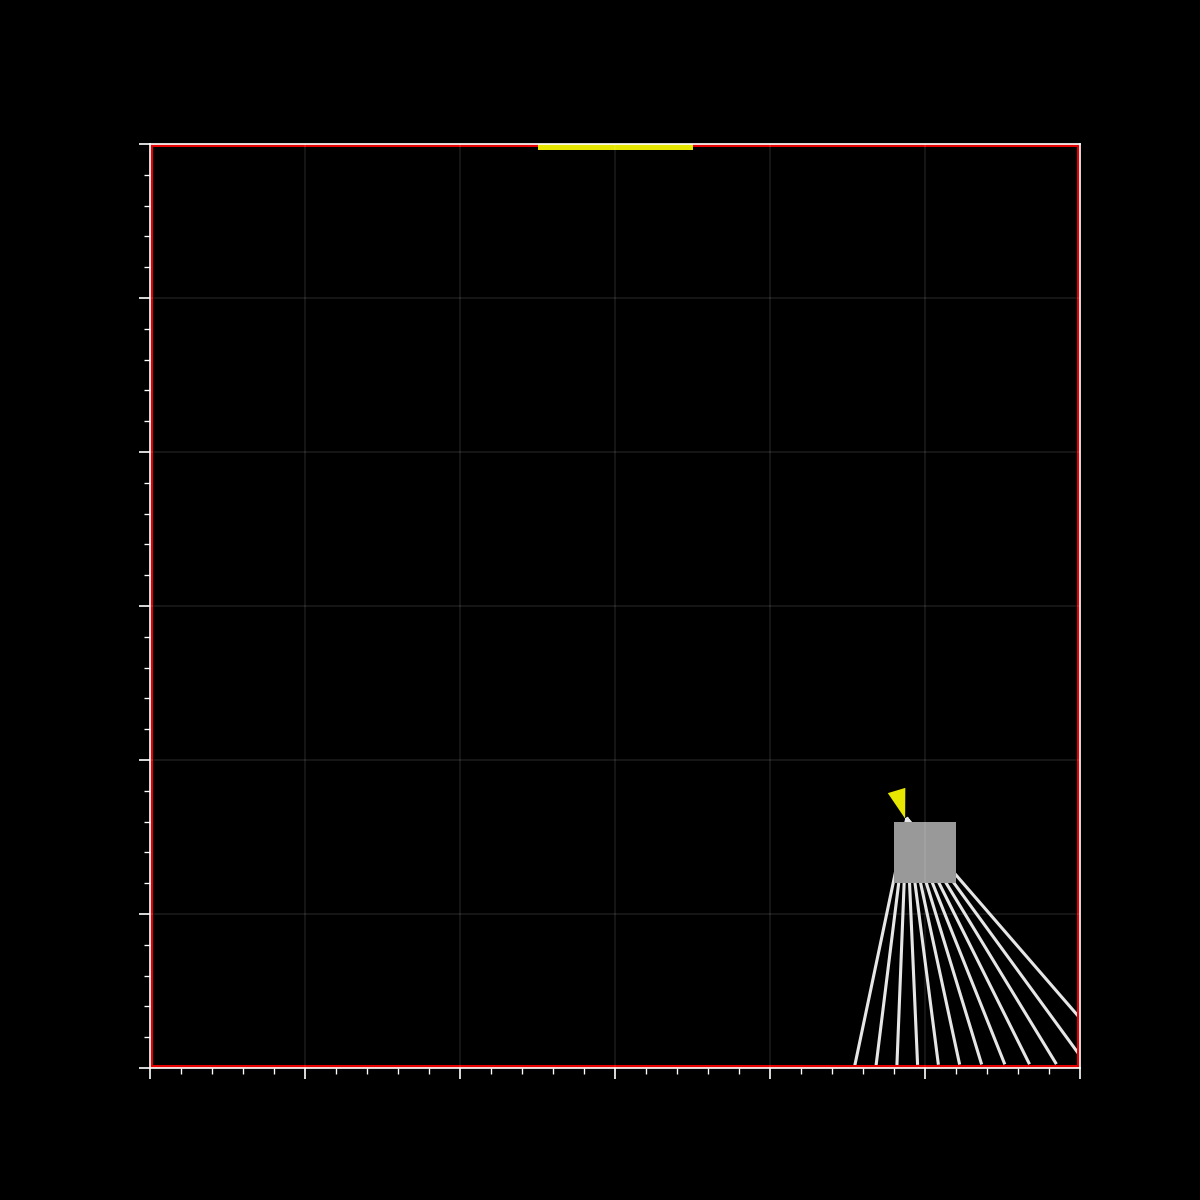

In [56]:
print(env.step(torch.tensor([[1]])))
env.render('human')

In [36]:
np.linalg.norm(envs.get_attr('character')[0].pos - envs.get_attr('boxes')[0][-1].center)

185.09814297225236

## Test categorical aux tasks

In [104]:
env_kwargs = {'num_objects': 0, 'rew_structure': 'goal',
              'task_structure': 2, 'wall_colors': 1, 'num_rays': 12, 'fov': 1,
              'poster': 1, 'auxiliary_tasks': [6], 'auxiliary_task_args': [None],
              'character_reset_pos': 1}
# env = gym.make('NavEnv-v0', **kwargs)
envs = make_vec_envs('NavEnv-v0', 0, 1, 0.99, '/tmp/gym/', torch.device('cpu'),
                     False, capture_video=False, env_kwargs=env_kwargs)
model = Policy(envs.observation_space.shape, envs.action_space, 
               base='FlexBase', base_kwargs={'hidden_size': 4, 'auxiliary_heads': [[-1, 0, 1]]})

obs = envs.reset()
rnn_hxs = torch.zeros(model.recurrent_hidden_state_size).view(1, -1)
masks = torch.ones([1, 1])

# model.base(obs, rnn_hxs, masks)
model.act(obs, rnn_hxs, masks)
envs.step(torch.tensor([[1]]))

(tensor([[ 0.0012,  0.0012,  0.0012,  0.0012,  0.0012,  0.0012,  0.0012,  0.0012,
           0.0012,  0.0012,  0.0012,  0.0012, -0.7812, -0.7854, -0.7913, -0.7990,
          -0.8084, -0.8194, -0.8318, -0.8455, -0.8601, -0.8753, -0.7181, -0.7047]]),
 tensor([[0.]]),
 array([False]),
 [{'auxiliary': array([3])}])

(tensor([[ 2.6275e-04,  2.6275e-04,  2.6275e-04,  2.6275e-04,  2.6275e-04,
          2.6275e-04,  2.6275e-04,  2.6275e-04,  2.6275e-04,  2.6275e-04,
          2.6275e-04,  2.6275e-04,  1.6293e+00,  1.8480e+00,  1.9980e+00,
          2.0179e+00,  9.3286e-01,  3.5469e-01, -4.8167e-02, -3.4495e-01,
         -4.9077e-01, -6.0529e-01, -6.9520e-01, -7.7069e-01]]), tensor([[6.2468]]), array([ True]), [{'auxiliary': array([1]), 'episode': {'r': 1.0, 'l': 38, 't': 27.836205}, 'terminal_observation': array([ 2.5969677e-04,  2.5969677e-04,  2.5969677e-04,  2.5969677e-04,
        2.5969677e-04,  2.5969677e-04,  2.5969677e-04,  2.5969677e-04,
        2.5969677e-04,  2.5969677e-04,  2.5969677e-04,  2.5969677e-04,
       -2.3029516e+00, -2.3708026e+00, -2.3603981e+00, -2.7123442e+00,
       -2.6802526e+00, -2.6192653e+00, -2.5013642e+00, -2.2755713e+00,
       -2.3475673e+00, -2.3238344e+00, -2.3836370e+00, -2.4771922e+00],
      dtype=float32)}])


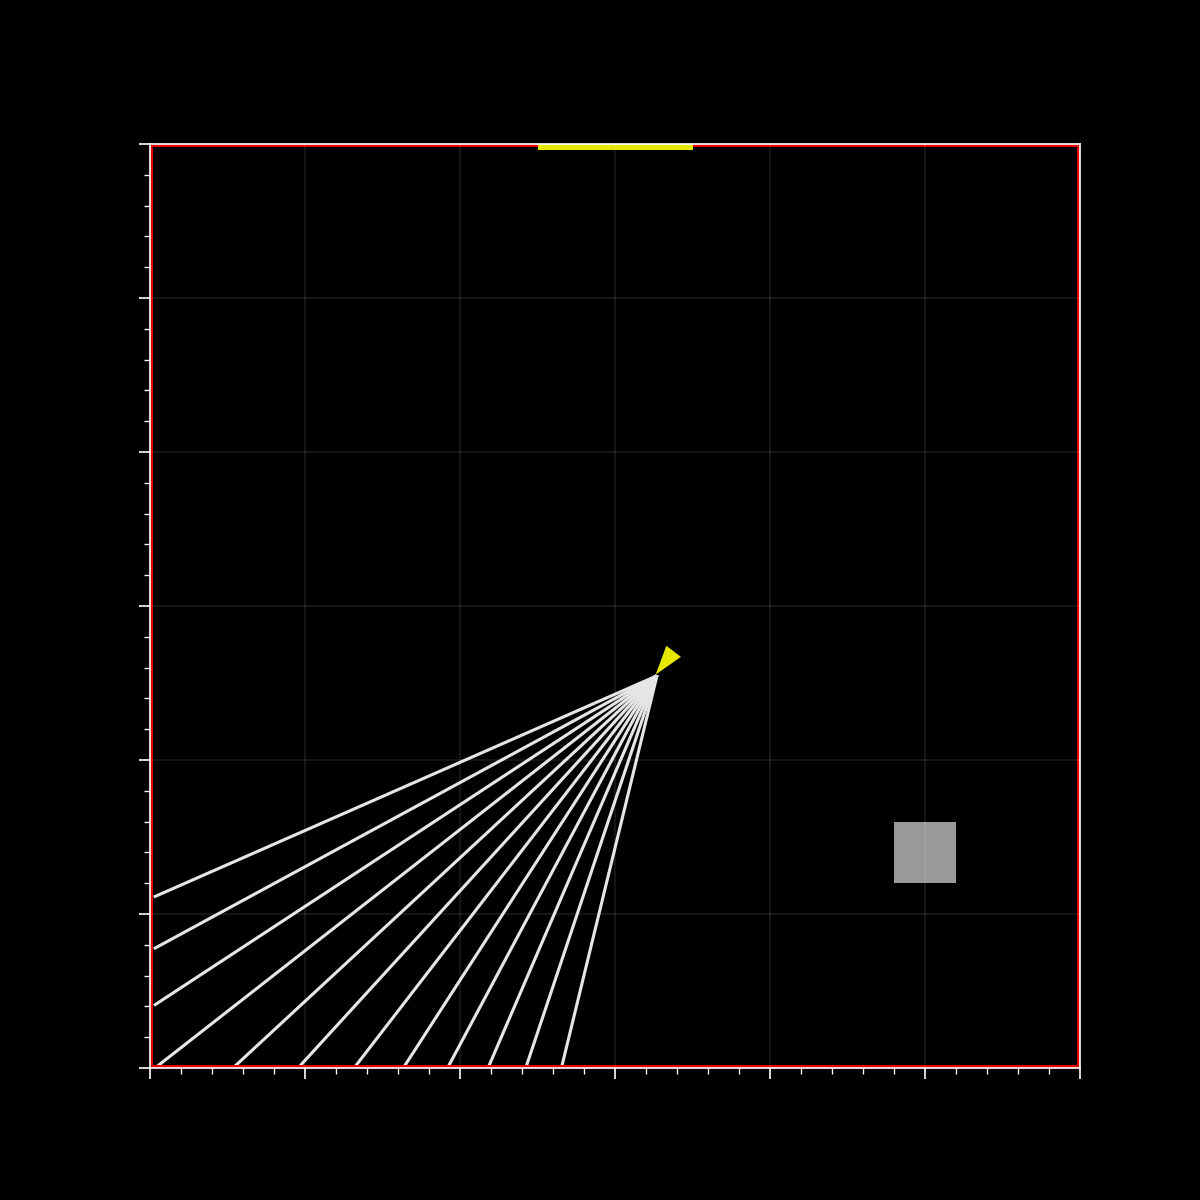

In [141]:
print(envs.step(torch.tensor([[1]])))
envs.get_attr('render')[0]()
# env = gym.make('NavEnv-v0', **env_kwargs)
# env.reset()
# env.render('human')

# Manual Testing of Training Code

In [143]:
import sys
sys.path.append('..')
from a2c_ppo_acktr.storage import RolloutStorage
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr import algo, utils
from  a2c_ppo_acktr.model import Policy
import torch
from collections import deque

'''
First 4 parameters are for shared recurrent layer. Can freeze these by setting
requires_grad = False
'''

def populate_rollouts(model, envs, rollouts, num_steps):
    for step in range(num_steps):
        #Generate rollouts for num_steps batch
        with torch.no_grad():
            outputs = model.act(rollouts.obs[step], rollouts.recurrent_hidden_states[step],
                                rollouts.masks[step])
            action = outputs['action']
            value = outputs['value']
            action_log_prob = outputs['action_log_probs']
            recurrent_hidden_states = outputs['rnn_hxs']
            # auxiliary_preds = outputs['auxiliary_preds']

        obs, reward, done, infos = envs.step(action)

        masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done])
        bad_masks = torch.FloatTensor([[0.0] if 'bad_transition' in info.keys() else [1.0] for info in infos])
        rollouts.insert(obs, recurrent_hidden_states, action, action_log_prob, value, reward, masks, bad_masks)

        
def update_model(agent, rollouts, use_gae=False, gamma=0.99, gae_lambda=0.95,
                 after_update=True):
    
    #Compute last value to be used for the update
    with torch.no_grad():
        next_value = agent.actor_critic.get_value(rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                                            rollouts.masks[-1]).detach()
    
    rollouts.compute_returns(next_value, use_gae, gamma, gae_lambda)
    value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss = agent.update(rollouts)
    
    if after_update:
        rollouts.after_update()
        
    return value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss


def initialize_ppo_training(model=None, obs_rms=None, env_name='NavEnv-v0', env_kwargs={},
                            nn_base='FlexBase', nn_base_kwargs={}, recurrent=True,
                            num_steps=10, num_processes=1, seed=0, ppo_epoch=4, clip_param=0.5,
                            num_mini_batch=1, value_loss_coef=0.5, entropy_coef=0.01, 
                            auxiliary_loss_coef=0.3, gamma=0.99, lr=7e-4, eps=1e-5, max_grad_norm=0.5,
                            log_dir='/tmp/gym/', device=torch.device('cpu'), 
                            capture_video=False):
    
    #Initialize vectorized environments
    envs = make_vec_envs(env_name, seed, num_processes, gamma, log_dir, device, False,
                         capture_video=capture_video, env_kwargs=env_kwargs)

    if model is None:
        model = Policy(envs.observation_space.shape,
                       envs.action_space,
                       base='FlexBase',
                       base_kwargs={'recurrent': recurrent,
                           **nn_base_kwargs})
        model.to(device)
    
    #Wrap model with an agent algorithm object
    agent = algo.PPO(model, clip_param, ppo_epoch, num_mini_batch,
                     value_loss_coef, entropy_coef, auxiliary_loss_coef, lr=lr,
                     eps=eps, max_grad_norm=max_grad_norm)


    #If loading a previously trained model, pass an obs_rms object to set the vec envs to use
    vec_norm = utils.get_vec_normalize(envs)
    if vec_norm is not None and obs_rms is not None:
        vec_norm.obs_rms = obs_rms


    #Initialize storage
    rollouts = RolloutStorage(num_steps, num_processes, envs.observation_space.shape, envs.action_space,
                              model.recurrent_hidden_state_size, model.auxiliary_output_size)
    #Storage objects initializes a bunch of empty tensors to store information, e.g.
    #obs has shape (num_steps+1, num_processes, obs_shape)
    #rewards has shape (num_steps, num_processes, 1)

    #obs, recurrent_hidden_states, value_preds, returns all have batch size num_steps+1
    #rewards, action_log_probs, actions, masks, auxiliary_preds, auxiliary_truths all have batch size num_steps
    obs = envs.reset()
    rollouts.obs[0].copy_(obs)
    rollouts.to(device)
    
    return agent, envs, rollouts

In [74]:
from model_evaluation import load_model_and_env

model_name = 'nav_poster_netstructure/nav_pdistal_width64batch200'
model, obs_rms, env_kwargs = load_model_and_env(model_name, 0)

In [36]:

vec_norm = utils.get_vec_normalize(envs)

In [95]:

from a2c_ppo_acktr.storage import RolloutStorage
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr import algo, utils
import torch
from collections import deque

#Overall training params
num_steps = 10 #batch steps
num_processes = 1
env_name = 'NavEnv-v0'
seed = 0
gamma = 0.99
log_dir = '/tmp/gym/'
device = torch.device('cpu')
capture_video = False

#Training update step params
use_gae = False
gae_lambda = 0.95

#Agent update params
clip_param = 0.2
ppo_epoch = 4
num_mini_batch = 1 #how many minibatches to divide our num_steps*num_processes batch of rollouts into
value_loss_coef = 0.5
entropy_coef = 0.01
auxiliary_loss_coef = 0.3
lr = 7e-4
eps = 1e-5
max_grad_norm = 0.5


num_updates = 1 #total batch_size updates to do

# episode_rewards = deque(maxlen=10)
agent, envs, rollouts = initialize_ppo_training(model, obs_rms, env_kwargs=env_kwargs)
for j in range(num_updates):
    populate_rollouts(model, envs, rollouts, num_steps)
    update_model(agent, rollouts, use_gae=use_gae, gamma=gamma, gae_lambda=gae_lambda)


In [27]:
'''
Testing freezing params

We load a trained model, freeze the recurrent layer and train, showing that indeed parameters
besides the recurrent layer have updated
'''

from model_evaluation import load_model_and_env

model_name = 'nav_poster_netstructure/nav_pdistal_width64batch200'
model, obs_rms, env_kwargs = load_model_and_env(model_name, 0)

params = list(model.parameters())
temp_param_vals = []
for i in range(4):
    params[i].requires_grad=False
for i in range(len(params)):
    temp_param_vals.append(params[i].data.clone())
# list(model.parameters())[0].requires_grad=False



num_updates = 1 #total batch_size updates to do
num_steps = 10

agent, envs, rollouts = initialize_ppo_training(model, obs_rms, env_kwargs=env_kwargs)
for j in range(num_updates):
    populate_rollouts(model, envs, rollouts, num_steps)
    update_model(agent, rollouts)
    
for i in range(len(params)):
    print(temp_param_vals[i].squeeze()[0] - params[i].data.squeeze()[0]) 

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(0.)
tensor(0.)
tensor([ 0.0020, -0.0001,  0.0021, -0.0019, -0.0016, -0.0021, -0.0022,  0.0019,
         0.0021,  0.0023, -0.0017, -0.0019,  0.0021, -0.0025, -0.0020, -0.0021,
        -0.0022,  0.0023,  0.0022, -0.0021, -0.0022,  0.0022, -0.0020,  0.0019,
        -0.0021, -0.0021, -0.0019, -0.0023,  0.0024, -0.0020, -0.0025,  0.0023,
        -0.0021,  0.0019,  0.0023,  0.0023,  0.0022,  0.0025, -0.0024,  0.0020,
         0.0022, -0.0021,  0.0018,  0.0020,  0.0022, -0.0021,  0.0020, -0.0020,
         0.0018,  0.0023,  0.0021, -0.0019,  0.0016,  0.0023, -0.0018,  0.0020,
        -0.0017, -0.0018, -0.002

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

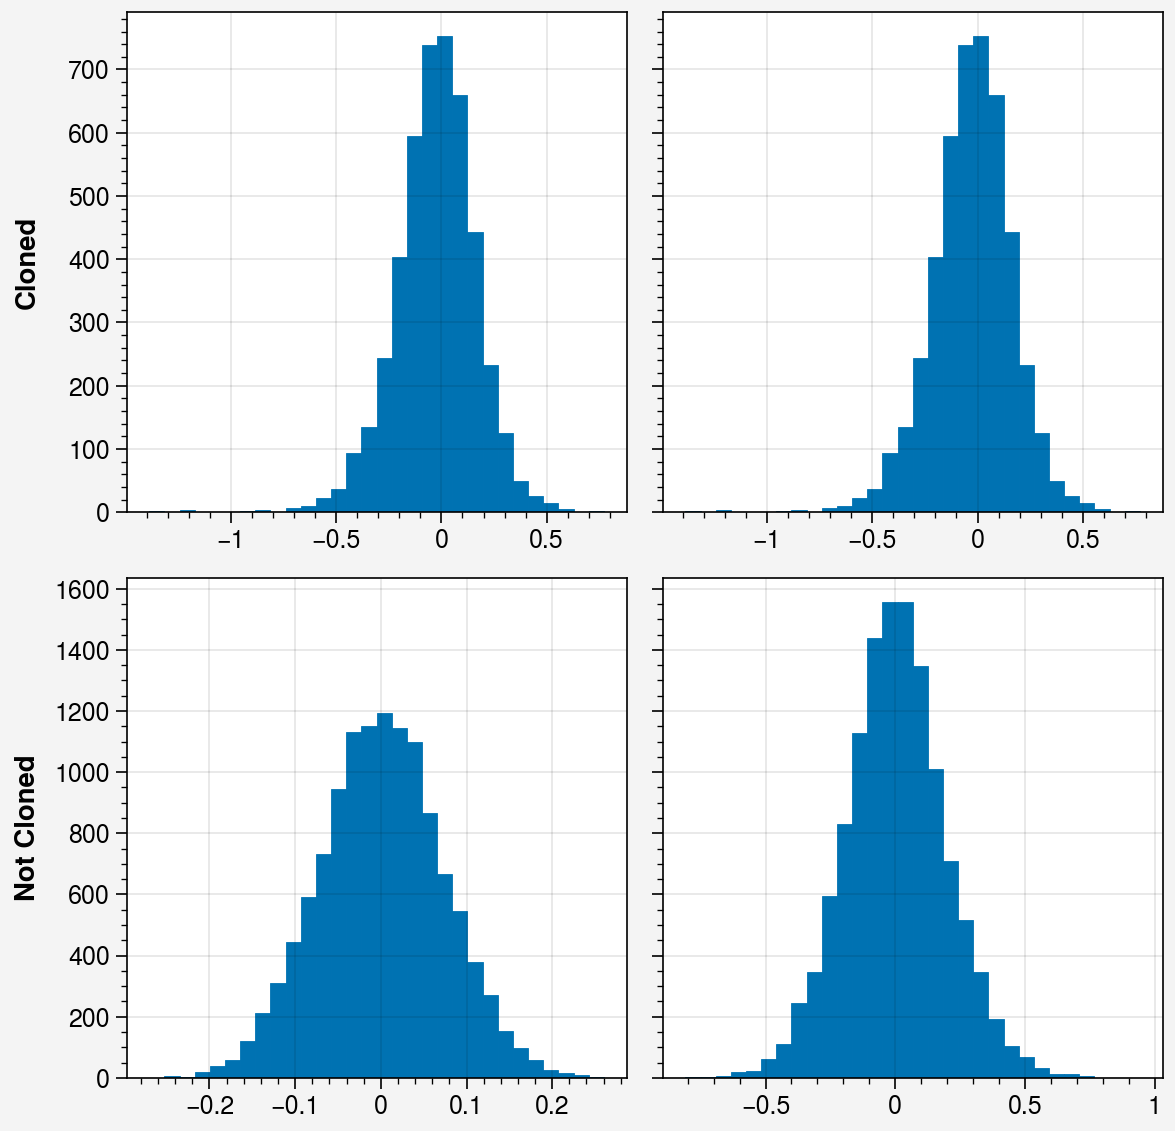

In [81]:
'''
Testing cloning params

We initiate a new model and then clone the first set of parameters from a trained model onto it
'''

from model_evaluation import load_model_and_env

model_name = 'nav_poster_netstructure/nav_pdistal_width64batch200'
model, obs_rms, env_kwargs = load_model_and_env(model_name, 0)

agent, envs, rollouts = initialize_ppo_training(env_kwargs=env_kwargs)



import matplotlib.pyplot as plt
import proplot as pplt

fig, ax = pplt.subplots(nrows=2, ncols=2, sharex=False)
ax.format(leftlabels=['Cloned', 'Not Cloned'])
params1 = list(agent.actor_critic.parameters())
params2 = list(model.parameters())

params1[0].data.copy_(params2[0].data)

for i in range(2):
    ax[i, 0].hist(params1[i].reshape(-1).detach().numpy(), bins=30)
    ax[i, 1].hist(params2[i].reshape(-1).detach().numpy(), bins=30)

# Manual Testing of env kwargs

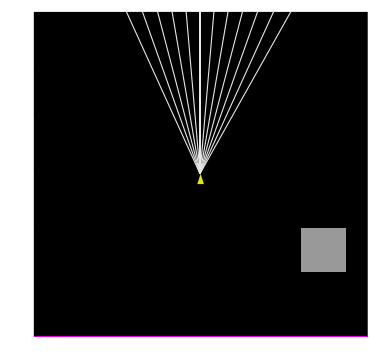

In [2]:
env_kwargs = pickle.load(open('../trained_models/ppo/meta_poster_width/meta_peast_fixposwidth16_env', 'rb'))
env_kwargs = pickle.load(open('../trained_models/ppo/meta_poster_width/meta_peast_fixposwidth16largegoal_env', 'rb'))
env_kwargs = pickle.load(open('../trained_models/ppo/report_poster_width/report_pdistal_width16_env', 'rb'))
env_kwargs = pickle.load(open('../trained_models/ppo/meta_poster/meta_c4_fixposwidth16largegoal_env', 'rb'))

env_kwargs['task_structure'] = 5

env = gym.make('NavEnv-v0', **env_kwargs)
env.reset()
env.render('human')

In [2]:
model_name = 'nav_poster_netstructure/nav_pdistal_width64batch200'
model, obs_rms, env_kwargs = load_model_and_env(model_name, 0)

list(model.parameters())[0]

Parameter containing:
tensor([[-0.2363, -0.1641, -0.2136,  ..., -0.0875, -0.0453,  0.0504],
        [ 0.0946,  0.1231,  0.0256,  ...,  0.1203,  0.4508,  0.4429],
        [ 0.0444,  0.1615,  0.0574,  ..., -0.0182, -0.1240, -0.2136],
        ...,
        [ 0.0231,  0.0861, -0.0638,  ...,  0.0427, -0.0582, -0.4408],
        [-0.0795, -0.0732, -0.0005,  ...,  0.0230, -0.0275,  0.0313],
        [ 0.3718,  0.0880,  0.1137,  ..., -0.0081, -0.0256,  0.0841]],
       requires_grad=True)

In [3]:
env_kwargs['task_structure'] = 3
env_kwargs['fixed_reset'] = [np.array([150., 150.]), np.pi/2]

In [4]:
env = gym.make('NavEnv-v0', **env_kwargs)

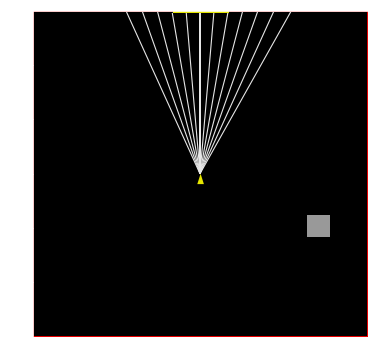

In [5]:
env.reset()
env.render('human')

In [26]:
print(env.step(torch.tensor([1])))
env.render('human')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [27]:
a = None

In [30]:
type(a) == type(None)

True

# Manual Testing of scheduler reader and main

In [41]:
%run ../testargs

# convert_config_to_command('nav_pdistal_width16clone1_t0', config_folder='../experiment_configs/')
# convert_config_to_command('nav_pdistal_width16auxwall1auxloss0.1_t0', config_folder='../experiment_configs/')
convert_config_to_command('meta_peast_width16_t0', config_folder='../experiment_configs/')

'python main.py --wandb-project-name Nav_Shared_Layers --exp-name meta_peast_width16_t0 --save-name meta_peast_width16_t0 --num-env-steps 5000 --env-name NavEnv-v0 --algo ppo --num-mini-batch 1 --num-processes 1 --num-steps 10 --recurrent --seed 0 --no-cuda --env-kwargs task_structure=3 rew_structure=goal num_objects=0 wall_colors=1 poster=1 num_rays=12 fov=1 character_reset_pos=1 fixed_reset=[array([150.,150.]),1.5707963267948966] max_steps=1000 --nn-base FlexBase --nn-base-kwargs hidden_size=16 --config-file-name meta_peast_width16_t0 '

In [6]:
%run ../testargs --wandb-project-name Nav_Shared_Layers --exp-name nav_pdistal_width16clone1_t0 --save-name nav_pdistal_width16clone1_t0 --num-env-steps 5000000 --env-name NavEnv-v0 --algo ppo --num-mini-batch 1 --num-processes 1 --num-steps 200 --checkpoint-interval 10 --recurrent --seed 0 --no-cuda --env-kwargs num_objects=0 rew_structure=goal task_structure=2 wall_colors=1 num_rays=12 fov=1 poster=1 character_reset_pos=1 --nn-base FlexBase --nn-base-kwargs hidden_size=16 --clone-parameter-experiment --clone-args clone_path=../trained_models/ppo/nav_poster_netstructure/nav_pdistal_width16batch200_t1.pt clone_layers=4 freeze=True --config-file-name nav_pdistal_width16clone1_t0

['num_objects=0', 'rew_structure=goal', 'task_structure=2', 'wall_colors=1', 'num_rays=12', 'fov=1', 'poster=1', 'character_reset_pos=1']
['hidden_size=16']
['clone_path=../trained_models/ppo/nav_poster_netstructure/nav_pdistal_width16batch200_t1.pt', 'clone_layers=4', 'freeze=True']


In [3]:
import copy
import glob
import os
import time
from collections import deque
from shutil import copyfile

import gym
import gym_nav
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from a2c_ppo_acktr import algo, utils
from a2c_ppo_acktr.algo import gail
from a2c_ppo_acktr.arguments import get_args
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr.model import Policy
from a2c_ppo_acktr.storage import RolloutStorage
from evaluation import evaluate

from scheduler import write_latest_exp_complete

ModuleNotFoundError: No module named 'evaluation'

In [27]:
device = torch.device("cuda:0" if args.cuda else "cpu")
print('initializing environments')
envs = make_vec_envs(args.env_name, args.seed, args.num_processes,
                     args.gamma, args.log_dir, device, False, capture_video=args.capture_video,
                     env_kwargs=args.env_kwargs)

loaded_model = False
# print(args.cont)
print('initializing model')
print(args.save_interval)

#Andy: for continuing an experiment, args.cont is True
if args.cont:
    loaded_model = True
    actor_critic, obs_rms = torch.load(save_path)

if not loaded_model:
    actor_critic = Policy(
        envs.observation_space.shape,
        envs.action_space,
        base=args.nn_base,
        base_kwargs={'recurrent': args.recurrent_policy, 
                     **args.nn_base_kwargs})

    #Andy: if cloning parameters, do it here. We are assuming
    #that the target cloning network has the appropriate parameter
    #sizes
    if args.clone_parameter_experiment:
        clone_args = args.clone_args
        clone_actor_critic, obs_rms = torch.load(clone_args['clone_path'])
        clone_layers = clone_args['clone_layers']
        freeze_layers = clone_args['freeze']

        clone_params = list(clone_actor_critic.parameters())
        actor_critic_params = list(actor_critic.parameters())

        if type(clone_layers) == int:
            clone_layers = range(clone_layers)
        if type(freeze_layers) == bool:
            freeze_layers = [freeze_layers]*len(clone_layers)
        for i, layer in enumerate(clone_layers):
            freeze = freeze_layers[i]

            actor_critic_params[layer].data.copy_(clone_params[layer].data)
            if freeze:
                actor_critic_params[layer].requires_grad = False

    actor_critic.to(device)

initializing environments
initializing model
100


# Terminal prediction wrapper

In [2]:
from stable_baselines3.common.vec_env import (DummyVecEnv, SubprocVecEnv,
                                              VecEnvWrapper)
import sys
sys.path.append('..')
from a2c_ppo_acktr.envs import make_env, VecNormalize, VecPyTorch, make_vec_envs
import proplot as pplt
from collections import deque

In [226]:
class AuxVecPyTorch(VecEnvWrapper):
    def __init__(self, venv, device, auxiliary_tasks=[], auxiliary_task_args=[]):
        """Return only every `skip`-th frame"""
        super(AuxVecPyTorch, self).__init__(venv)
        self.device = device
        
        available_auxiliary_tasks = {
            'terminal': 1
        }
        auxiliary_task_to_idx = {
            'terminal': 0
        }
        
        self.auxiliary_tasks = []
        self.auxiliary_task_args = auxiliary_task_args
        for task in auxiliary_tasks:
            if type(task) == int:
                self.auxiliary_tasks.append(task)
            elif task not in available_auxiliary_tasks.keys():
                raise NotImplementedError('Auxiliary task {} not found. Available options are '.format(
                    task, ', '.join(available_auxiliary_tasks.keys())))
            else:
                self.auxiliary_tasks.append(auxiliary_task_to_idx[task])

        self.episode_lengths = deque(maxlen=200)
        self.episode_lengths.append(200)

    def reset(self):
        obs = self.venv.reset()
        obs = torch.from_numpy(obs).float().to(self.device)
        return obs

    def step_async(self, actions):
        if isinstance(actions, torch.LongTensor):
            # Squeeze the dimension for discrete actions
            actions = actions.squeeze(1)
        actions = actions.cpu().numpy()
        self.venv.step_async(actions)

    def step_wait(self):
        obs, reward, done, info = self.venv.step_wait()
        obs = torch.from_numpy(obs).float().to(self.device)
        reward = torch.from_numpy(reward).unsqueeze(dim=1).float()
        
        
        for t, task in enumerate(self.auxiliary_tasks):
            #Note we assume that 'current_steps' is an attribute of the
            # environment. We could rewrite this so that the wrapper itself
            # keeps track of step counts so it becomes fully environment independent
            if task == 0:
                steps = self.venv.get_attr('current_steps')
                mean_steps = np.mean(self.episode_lengths)
                for n, i in enumerate(info):
                    if 'episode' in i.keys():
                        self.episode_lengths.append(i['episode']['l'])
                    if 'auxiliary' in i.keys():
                        i['auxiliary'] = np.append(i['auxiliary'], [steps[n]/mean_steps])
                    else:
                        i['auxiliary'] = np.array([steps[n]/mean_steps])
        
        
        return obs, reward, done, info

In [8]:
env_kwargs = pickle.load(open('../trained_models/ppo/nav_pdistal_batchaux/nav_pdistal_batch128auxnone_env', 'rb'))

In [4]:
env_kwargs = pickle.load(open('../trained_models/ppo/nav_poster_netstructure/nav_pdistal_width16batch200_env', 'rb'))

In [150]:
env = gym.make('NavEnv-v0', **env_kwargs)

In [20]:
aux_wrapper_args = {
    'auxiliary_tasks': [0],
    'auxiliary_task_args': [None]
}

envs = make_vec_envs('NavEnv-v0', 0, 5, 0.99, '/tmp/gym/', torch.device('cpu'),
                     False, capture_video=False, env_kwargs=env_kwargs, **aux_wrapper_args)


In [163]:


envs = [make_env('NavEnv-v0', 0, i, '/tmp/gym/', False, False, env_kwargs)
       for i in range(5)]

envs2 = SubprocVecEnv(envs)

envs3 = VecNormalize(envs2)

# envs4 = VecPyTorch(envs3, torch.device('cpu'))
envs4 = AuxVecPyTorch(envs3, torch.device('cpu'))

In [8]:
config = pickle.load(open('../experiment_configs/nav_pdistal_batch16auxrewexplorenonorm_t1', 'rb'))
env_kwargs = config['env_kwargs']

In [19]:
envs = make_vec_envs('NavEnv-v0', 0, 1, 0.99, '/tmp/gym/_eval/', torch.device('cpu'), True,
                    capture_video=False, env_kwargs=env_kwargs)

In [21]:
envs.reset()

tensor([[0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
         0.0016, 0.0016, 0.0016, 0.0036, 0.0037, 0.0037, 0.0038, 0.0040, 0.0041,
         0.0043, 0.0046, 0.0049, 0.0052, 0.0052, 0.0050]])

In [24]:
envs.step(torch.zeros((1, 1)))

(tensor([[ 9.4900e-04,  9.4900e-04,  9.4900e-04,  9.4900e-04,  9.4900e-04,
           9.4900e-04,  9.4900e-04,  9.4900e-04,  9.4900e-04,  9.4900e-04,
           9.4900e-04,  9.4900e-04,  8.6678e-01,  4.2426e-02, -6.1091e-01,
          -8.7525e-01, -9.8642e-01, -1.0402e+00, -1.0684e+00, -1.0831e+00,
          -1.0895e+00, -1.0899e+00, -1.2701e+00, -1.3759e+00]]),
 tensor([[0.]]),
 array([False]),
 [{'auxiliary': array([], dtype=float64)}])

In [9]:
envs = make_vec_envs('NavEnv-v0', 0, 5, 0.99, '/tmp/gym/', torch.device('cpu'),
                     False, capture_video=False, env_kwargs=env_kwargs, normalize=False)


In [3]:
exp_name = 'nav_pdistal_batchaux/nav_pdistal_batch16auxterminal'
model, obs_rms, env_kwargs = load_model_and_env(exp_name, 0)

In [6]:
res = evalu(model, obs_rms, n=1, env_kwargs=env_kwargs)

In [14]:
model.act(res['obs'][0], res['hidden_states'][0], res['masks'][0], deterministic=True)

{'value': tensor([[4.9850]], grad_fn=<AddmmBackward0>),
 'actor_features': tensor([[-0.9946,  0.8956, -0.6420,  0.7769,  0.9998, -0.5255,  0.3774,  0.9990,
          -0.9446,  0.8955, -0.9536, -0.9977, -0.5088, -0.9830,  0.7390, -0.9674]],
        grad_fn=<TanhBackward0>),
 'rnn_hxs': tensor([[ 0.1480, -0.3221,  0.0209,  0.0756,  0.1212,  0.1591,  0.0211, -0.0037,
           0.3851, -0.5516, -0.0028,  0.5860,  0.0772, -0.1012,  0.0219,  0.9141]],
        grad_fn=<SqueezeBackward1>),
 'auxiliary_preds': tensor([[0.2027]], grad_fn=<CopySlices>),
 'action': tensor([[0]]),
 'action_log_probs': tensor([[-0.0002]], grad_fn=<UnsqueezeBackward0>)}

In [2]:
#load model
exp_name = 'nav_pdistal_batchaux/nav_pdistal_batch16auxwall0'
model, obs_rms, env_kwargs = load_model_and_env(exp_name, 0)

In [3]:
#test running an episode and collecting with evalu
res = evalu(model, obs_rms, n=1, env_kwargs=env_kwargs)

In [4]:
#test outputs from model (auxiliary preds comes from here)
model.act(res['obs'][0], res['hidden_states'][0], res['masks'][0], deterministic=True)

{'value': tensor([[4.9307]], grad_fn=<AddmmBackward0>),
 'actor_features': tensor([[-0.9399,  0.9983, -0.9987, -0.5419,  0.9782, -0.9849,  0.8081,  0.9931,
          -0.9986,  0.9996, -0.9960, -0.9131, -0.9977, -0.9667,  0.9399,  0.9975]],
        grad_fn=<TanhBackward0>),
 'rnn_hxs': tensor([[-4.1558e-02, -5.5024e-01,  5.7602e-01, -4.0308e-06,  5.4678e-01,
          -9.6831e-01,  8.3329e-02, -6.0160e-01, -1.0827e-01, -9.7619e-01,
           7.7868e-02,  6.8784e-01, -7.9954e-02, -1.3241e-01, -5.5716e-01,
           6.7399e-01]], grad_fn=<SqueezeBackward1>),
 'auxiliary_preds': tensor([[0.5400]], grad_fn=<CopySlices>),
 'action': tensor([[0]]),
 'action_log_probs': tensor([[-3.1471e-05]], grad_fn=<UnsqueezeBackward0>)}

In [5]:
#test outputs from envs step
envs = make_vec_envs('NavEnv-v0', 0, 1, 0.99, '/tmp/gym/_eval/', torch.device('cpu'), True,
                    capture_video=False, env_kwargs=env_kwargs)
envs.reset()
envs.step(torch.zeros((1, 1)))

(tensor([[ 0.0012,  0.0012,  0.0012,  0.0012,  0.0012,  0.0012,  0.0012,  0.0012,
           0.0012,  0.0012,  0.0012,  0.0012, -0.2255, -0.5538, -0.7459, -0.8497,
          -0.9074, -0.9412, -0.9620, -0.9753, -0.9839, -0.9897, -0.9651,  0.7729]]),
 tensor([[0.]]),
 array([False]),
 [{'auxiliary': array([0.85813523])}])

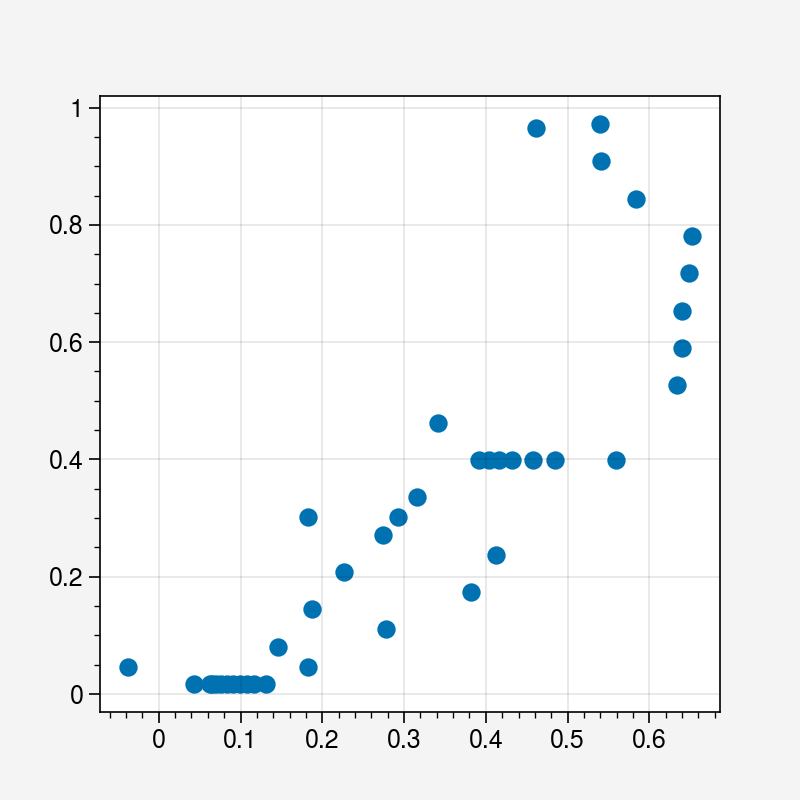

In [7]:
plt.scatter(torch.vstack(res['auxiliary_preds']), torch.vstack(res['auxiliary_truths']))

# Test new auxiliary task trainers

In [68]:
torch.autograd.set_detect_anomaly(True)

In [1]:
import sys
sys.path.append('..')

from a2c_ppo_acktr.distributions import Bernoulli, Categorical, DiagGaussian
import gym
import gym_nav
import torch
%run model_evaluation
%run gradients
%run ../a2c_ppo_acktr/model
%run ../a2c_ppo_acktr/storage
%run ../a2c_ppo_acktr/algo/ppo

In [77]:
exp_name = 'nav_pdistal_batchaux/nav_pdistal_batch32auxwall01'
_, _, env_kwargs = load_model_and_env(exp_name, 0)
env_kwargs['separate_aux_tasks'] = True

num_steps = 16
num_envs = 2


envs = make_vec_envs('NavEnv-v0', 0, num_envs, 0.99, '/tmp/gym/_eval/', torch.device('cpu'), True,
                    capture_video=False, env_kwargs=env_kwargs)


# base = FlexBaseAux(num_inputs=envs.observation_space.shape[0], hidden_size=16, auxiliary_heads=[[-1, 0, 1, 4]])
# base = FlexBase(num_inputs=envs.observation_space.shape[0], hidden_size=16, auxiliary_heads=[[-1, 0, 1]])

actor_critic = Policy(envs.observation_space.shape, envs.action_space, base='FlexBaseAux',
      base_kwargs={'auxiliary_heads': [[-1, 0, 0, 1], [-1, 0, 0, 1]], 'hidden_size':16})
rollouts = RolloutStorageAux(num_steps, num_envs,
                          envs.observation_space.shape, envs.action_space,
                          actor_critic.recurrent_hidden_state_size,
                          actor_critic.auxiliary_output_sizes, auxiliary_truth_sizes = [1, 1])
agent = PPOAux(actor_critic, 0.2, 1, 1, 0.5, 0.01, 0.5, lr=7e-4, eps=1e-5, max_grad_norm=0.5)
# rollouts = RolloutStorage(16, 1,
#                           envs.observation_space.shape, envs.action_space,
#                           base.recurrent_hidden_state_size,
#                           base.auxiliary_output_size)


obs = envs.reset()
rollouts.obs[0] = obs



for step in range(num_steps):
    outputs = actor_critic.act(rollouts.obs[step], rollouts.recurrent_hidden_states[step],
        rollouts.masks[step])
    action = outputs['action']

    obs, reward, done, infos = envs.step(action)

    value = outputs['value']
    action_log_prob = outputs['action_log_probs']
    recurrent_hidden_states = outputs['rnn_hxs']
    auxiliary_preds = outputs['auxiliary_preds']
    masks = torch.FloatTensor(
        [[0.0] if done_ else [1.0] for done_ in done])
    bad_masks = torch.FloatTensor(
        [[0.0] if 'bad_transition' in info.keys() else [1.0]
         for info in infos])



    auxiliary_truths = [[] for i in range(len(actor_critic.auxiliary_output_sizes))]
    for info in infos:
        if 'auxiliary' in info and len(info['auxiliary']) > 0:
            for i, aux in enumerate(info['auxiliary']):
                auxiliary_truths[i].append(aux)
    if len(auxiliary_truths) > 0:
        auxiliary_truths = [torch.tensor(np.vstack(aux)) for aux in auxiliary_truths]

    rollouts.insert(obs, recurrent_hidden_states, action,
                    action_log_prob, value, reward, masks, bad_masks,
                    auxiliary_preds, auxiliary_truths)



In [3]:
exp_name = 'nav_pdistal_batchaux/nav_pdistal_batch32auxwall01'
_, _, env_kwargs = load_model_and_env(exp_name, 0)
env_kwargs['separate_aux_tasks'] = True
envs = make_vec_envs('NavEnv-v0', 0, 2, 0.99, '/tmp/gym/_eval/', torch.device('cpu'), True,
                    capture_video=False, env_kwargs=env_kwargs)
actor_critic = Policy(envs.observation_space.shape, envs.action_space, base='FlexBaseAux',
      base_kwargs={'auxiliary_heads': [[-1, 0, 0, 1], [-1, 0, 0, 1]], 'hidden_size':16})


In [6]:
actor_critic.auxiliary_output_sizes

[1, 1]

In [70]:

#test update
with torch.no_grad():
    next_value = actor_critic.get_value(
        rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
        rollouts.masks[-1]).detach()

rollouts.compute_returns(next_value, False, 0.99,
                     0.99, False)

value_loss, action_loss, dist_entropy, approx_kl, clipfracs, \
            auxiliary_loss = agent.update(rollouts)

<MulBackward0 object at 0x0000024A10F8CB50> <NegBackward0 object at 0x0000024A1313AB80> <SumBackward0 object at 0x0000024A1313AFA0> <MeanBackward0 object at 0x0000024A1313ABB0>


C:\Users\14and\anaconda3\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "C:\Users\14and\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\14and\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\14and\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\14and\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\14and\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
    self.io_loop.start()
  File "C:\Users\14and\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\14and\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
    

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [2, 24]] is at version 17; expected version 16 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [78]:
advantages = rollouts.returns[:-1] - rollouts.value_preds[:-1]
advantages = (advantages - advantages.mean()) / (
    advantages.std() + 1e-5)

data_generator = rollouts.recurrent_generator(
    advantages, 1)


for sample in data_generator:
    print('sample')
    obs_batch, recurrent_hidden_states_batch, actions_batch, \
                       value_preds_batch, return_batch, masks_batch, old_action_log_probs_batch, \
                        adv_targ, auxiliary_pred_batch, auxiliary_truth_batch = sample
    # print(auxiliary_pred_batch)
    
values, action_log_probs, dist_entropy, _, auxiliary_preds = actor_critic.evaluate_actions(
                    obs_batch, recurrent_hidden_states_batch, masks_batch,
                    actions_batch)

sample


## Using existing training code

In [2]:
import sys
sys.path.append('..')
from tqdm import tqdm
from sklearn.metrics import accuracy_score

%run model_evaluation
%run gradients

# from a2c_ppo_acktr.storage import RolloutStorageAux
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr import algo, utils
import torch
from collections import deque
%run ../a2c_ppo_acktr/model
%run ../a2c_ppo_acktr/storage
%run ../a2c_ppo_acktr/algo/ppo

exp_name = 'nav_pdistal_widthaux/nav_pdistal_width32auxwall01'
model, obs_rms, env_kwargs = load_model_and_env(exp_name, 0)
env_kwargs['separate_aux_tasks'] = True
# env_kwargs['auxiliary_tasks'] = [4, 5, 2]
# env_kwargs['auxiliary_task_args'] = [None, None, None]
# env_kwargs['auxiliary_tasks'] = [5, 5]
# env_kwargs['auxiliary_task_args'] = [0, 1]
env_kwargs['auxiliary_tasks'] = []
env_kwargs['auxiliary_task_args'] = []

#Overall training params
num_steps = 100 #batch steps
num_processes = 1
env_name = 'NavEnv-v0'
seed = 0
gamma = 0.99
log_dir = '/tmp/gym/'
device = torch.device('cpu')
capture_video = False

#Training update step params
use_gae = False
gae_lambda = 0.95

#Agent update params
clip_param = 0.2
ppo_epoch = 4
num_mini_batch = 1 #how many minibatches to divide our num_steps*num_processes batch of rollouts into
value_loss_coef = 0.5
entropy_coef = 0.01
auxiliary_loss_coef = 0.3
lr = 7e-4
eps = 1e-5
max_grad_norm = 0.5


num_updates = 10 #total batch_size updates to do

agent, envs, rollouts = initialize_ppo_training(None, obs_rms=obs_rms, env_kwargs=env_kwargs, num_steps=num_steps, num_processes=num_processes,
# # agent, envs, rollouts = initialize_ppo_training(model, obs_rms=obs_rms, env_kwargs=env_kwargs, num_steps=num_steps, num_processes=num_processes,
#                                         #        auxiliary_truth_sizes=[1, 1, 1],
#                                         # nn_base_kwargs={'auxiliary_heads': [[-1, 0, 1, 4], [-1, 0, 1, 2], [-1, 0, 0, 1]], 'hidden_size':16})
#                                                auxiliary_truth_sizes=[1],
                                        # nn_base_kwargs={'auxiliary_heads': [[-1, 0, 1, 2], [-1, 0, 1, 2]], 'hidden_size':32}, auxiliary_truth_sizes=[1, 1])
                                        nn_base_kwargs={'auxiliary_heads': [], 'hidden_size':32}, auxiliary_truth_sizes=[])




# model = Policy(envs.observation_space.shape, envs.action_space, base='FlexBaseAux',
      # base_kwargs={'auxiliary_heads': [[-1, 0, 1, 4], [-1, 0, 1, 2], [-1, 0, 0, 1]], 'hidden_size':16})




# episode_rewards = deque(maxlen=10)
# agent, envs, rollouts = initialize_ppo_training(model, obs_rms, env_kwargs=env_kwargs)
# agent, envs, rollouts = initialize_ppo_training(model, env_kwargs=env_kwargs, num_steps=num_steps, num_processes=num_processes,
#                                                auxiliary_truth_sizes=[1, 1, 1])
# agent, envs, rollouts = initialize_ppo_training(env_kwargs=env_kwargs, num_steps=num_steps, num_processes=num_processes,
#                                                auxiliary_truth_sizes=[1, 1, 1], nn_base_kwargs = )


auxiliary_losses = []
accuracies = [[] for i in range(len(env_kwargs['auxiliary_tasks']))]
rewards = []

'''Old auxiliary training models'''
# #Old auxiliary training
# agent, envs, rollouts = initialize_ppo_training(model, obs_rms=obs_rms, env_kwargs=env_kwargs, num_steps=num_steps, num_processes=num_processes,
#                                                new_aux=False)
# #With copying
# agent, envs, rollouts = initialize_ppo_training(None, obs_rms=obs_rms, env_kwargs=env_kwargs, num_steps=num_steps, num_processes=num_processes,
#                                                new_aux=False, nn_base_kwargs={'hidden_size': 32})

#copy actor-critic params from trained model
copy_params = list(model.parameters())
paste_params = list(agent.actor_critic.parameters())
param_idxs = list(range(16)) + [-2, -1]
for i in param_idxs:    
    paste_params[i].requires_grad = False
    paste_params[i].copy_(copy_params[i].detach())
    paste_params[i].requires_grad = True


for j in tqdm(range(1)):
# for j in range(1):
    # populate_rollouts_aux(trained_model, envs, rollouts, num_steps)
    populate_rollouts_aux(agent.actor_critic, envs, rollouts, num_steps)
    # populate_rollouts(model, envs, rollouts, num_steps)
    
    for i in range(len(env_kwargs['auxiliary_tasks'])):
        y_pred = rollouts.auxiliary_preds[i].argmax(axis=2).squeeze()
        y_true = rollouts.auxiliary_truths[i].long().squeeze()
        accuracies[i].append(accuracy_score(y_pred, y_true))
    rewards.append(rollouts.rewards.sum().item())
    value_loss, action_loss, entropy_loss, _, _, auxiliary_loss = update_model(agent, rollouts, use_gae=use_gae, gamma=gamma, gae_lambda=gae_lambda)
    auxiliary_losses.append(auxiliary_loss)
    
    

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]
None
[]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


In [13]:
agent.actor_critic.act(rollouts.obs[0], rollouts.recurrent_hidden_states[0], rollouts.masks[0])

{'value': tensor([[5.2297]], grad_fn=<AddmmBackward0>),
 'actor_features': tensor([[ 0.6348,  0.9956,  0.9945, -0.2704, -0.5714, -0.6300, -0.8960, -0.9866,
          -0.1319, -0.9841, -0.6540,  0.9857,  0.9996, -0.3777, -0.9609, -0.9529,
          -0.4594, -0.9842, -0.9995,  0.9969, -0.9993, -0.8947, -0.9972,  0.9741,
           0.9624, -0.9819,  0.9962,  0.4406,  0.9837,  0.9596, -0.4873,  0.9969]],
        grad_fn=<TanhBackward0>),
 'rnn_hxs': tensor([[-0.1333,  0.0786,  0.3441, -0.0186,  0.0890, -0.0948,  0.6527, -0.4712,
           0.1863,  0.0237, -0.1212,  0.2959, -0.4154,  0.0866,  0.1303,  0.4519,
           0.0233, -0.3922, -0.1254,  0.0104, -0.2635, -0.0969,  0.4202,  0.3259,
          -0.4731, -0.1203,  0.3826,  0.2670,  0.0266, -0.0429, -0.4227,  0.2277]],
        grad_fn=<SqueezeBackward1>),
 'auxiliary_preds': tensor([[0.]]),
 'action': tensor([[0]]),
 'action_log_probs': tensor([[-0.0003]], grad_fn=<UnsqueezeBackward0>)}

In [15]:
agent.actor_critic.has_auxiliary

False

In [4]:
auxiliary_preds

NameError: name 'auxiliary_preds' is not defined

In [7]:
agent.auxiliary_output_sizes

NameError: name 'agent' is not defined

In [200]:
for j in tqdm(range(100)):
# for j in range(1):
    # populate_rollouts_aux(trained_model, envs, rollouts, num_steps)
    populate_rollouts(agent.actor_critic, envs, rollouts, num_steps)
    # populate_rollouts(model, envs, rollouts, num_steps)
    
    for i in range(len(env_kwargs['auxiliary_tasks'])):
        y_pred = rollouts.auxiliary_preds[i].argmax(axis=2).squeeze()
        y_true = rollouts.auxiliary_truths[i].long().squeeze()
        accuracies[i].append(accuracy_score(y_pred, y_true))
    rewards.append(rollouts.rewards.sum().item())
    value_loss, action_loss, entropy_loss, _, _, auxiliary_loss = update_model(agent, rollouts, use_gae=use_gae, gamma=gamma, gae_lambda=gae_lambda)
    auxiliary_losses.append(auxiliary_loss)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.48it/s]


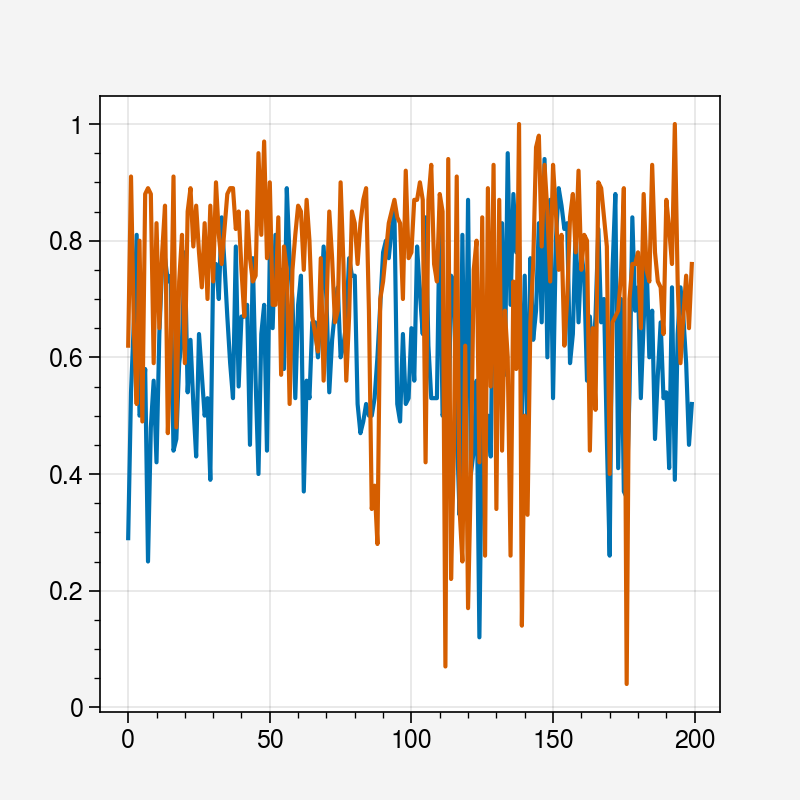

In [201]:
for i in range(len(env_kwargs['auxiliary_tasks'])):
    plt.plot(accuracies[i])

In [137]:
agent.actor_critic.act(rollouts.obs[0], rollouts.recurrent_hidden_states[0], rollouts.masks[0])

{'value': tensor([[5.2297]], grad_fn=<AddmmBackward0>),
 'actor_features': tensor([[ 0.6348,  0.9956,  0.9945, -0.2704, -0.5714, -0.6300, -0.8960, -0.9866,
          -0.1319, -0.9841, -0.6540,  0.9857,  0.9996, -0.3777, -0.9609, -0.9529,
          -0.4594, -0.9842, -0.9995,  0.9969, -0.9993, -0.8947, -0.9972,  0.9741,
           0.9624, -0.9819,  0.9962,  0.4406,  0.9837,  0.9596, -0.4873,  0.9969]],
        grad_fn=<TanhBackward0>),
 'rnn_hxs': tensor([[-0.1333,  0.0786,  0.3441, -0.0186,  0.0890, -0.0948,  0.6527, -0.4712,
           0.1863,  0.0237, -0.1212,  0.2959, -0.4154,  0.0866,  0.1303,  0.4519,
           0.0233, -0.3922, -0.1254,  0.0104, -0.2635, -0.0969,  0.4202,  0.3259,
          -0.4731, -0.1203,  0.3826,  0.2670,  0.0266, -0.0429, -0.4227,  0.2277]],
        grad_fn=<SqueezeBackward1>),
 'auxiliary_preds': tensor([[0.]]),
 'action': tensor([[1]]),
 'action_log_probs': tensor([[-1.3863]], grad_fn=<UnsqueezeBackward0>)}

In [39]:
import matplotlib.pyplot as plt

In [180]:
for j in tqdm(range(100)):
# for j in range(1):
    # populate_rollouts_aux(trained_model, envs, rollouts, num_steps)
    populate_rollouts(agent.actor_critic, envs, rollouts, num_steps)
    # populate_rollouts(model, envs, rollouts, num_steps)
    
    y_pred = rollouts.auxiliary_preds[0].argmax(axis=2).squeeze()
    y_true = rollouts.auxiliary_truths[0].long().squeeze()
    accuracies.append(accuracy_score(y_pred, y_true))
    rewards.append(rollouts.rewards.sum().item())
    value_loss, action_loss, entropy_loss, _, _, auxiliary_loss = update_model(agent, rollouts, use_gae=use_gae, gamma=gamma, gae_lambda=gae_lambda)
    auxiliary_losses.append(auxiliary_loss)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.55it/s]


In [190]:
rollouts.auxiliary_preds[0].squeeze().argmax(axis=1)

tensor([1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0])

In [189]:
rollouts.auxiliary_truths[0].squeeze().long()

tensor([3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3])

In [191]:
evalu

<function model_evaluation.evalu(model, obs_rms, n=100, env_name='NavEnv-v0', env_kwargs={}, data_callback=None, capture_video=False, verbose=0, with_activations=False, seed=1, deterministic=True, normalize=True, aux_wrapper_kwargs={})>

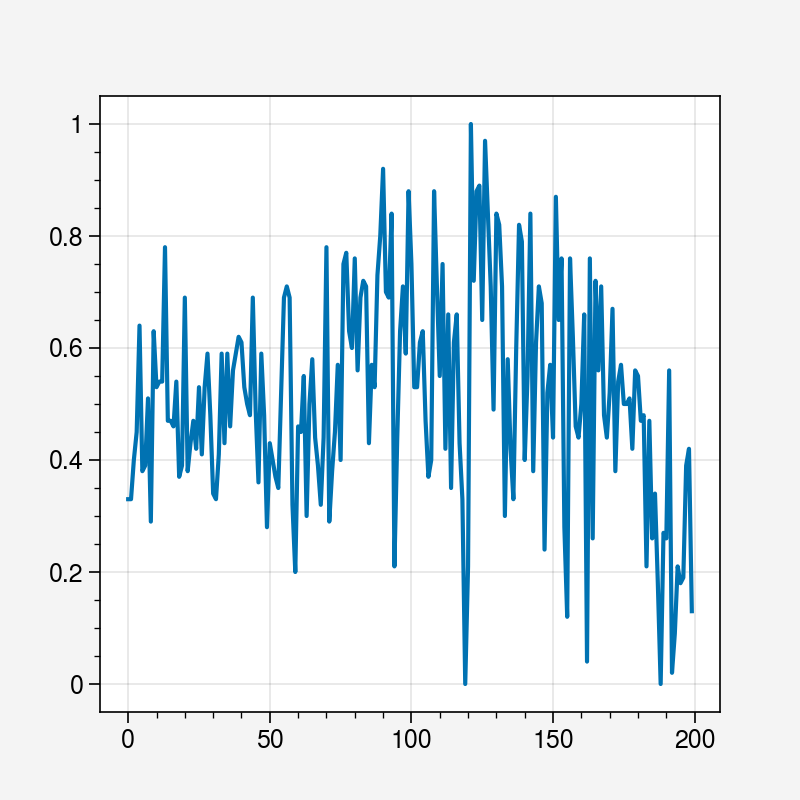

In [181]:
plt.plot(accuracies)

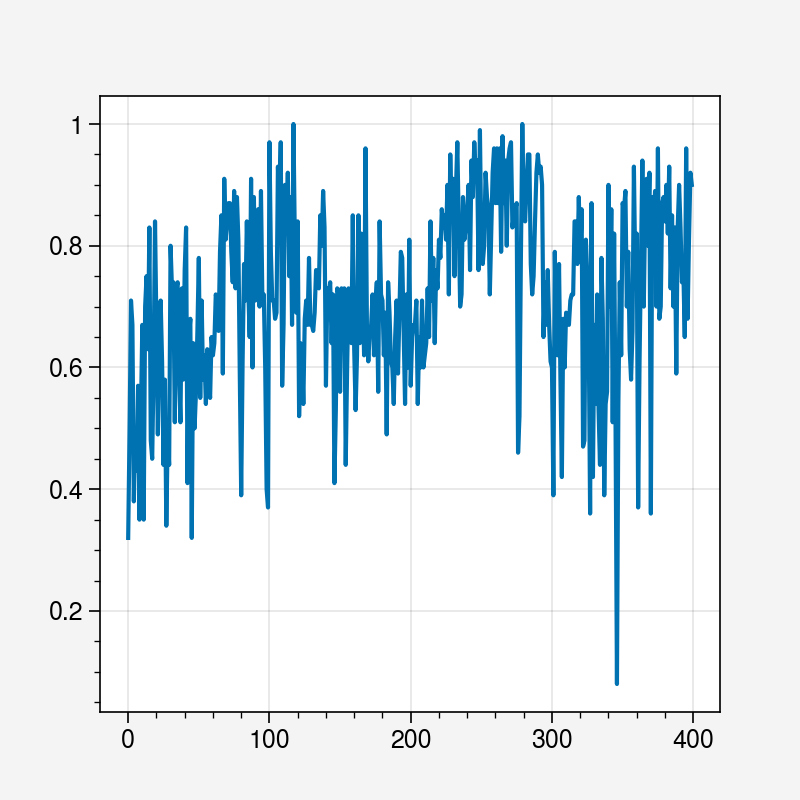

In [164]:
plt.plot(accuracies)

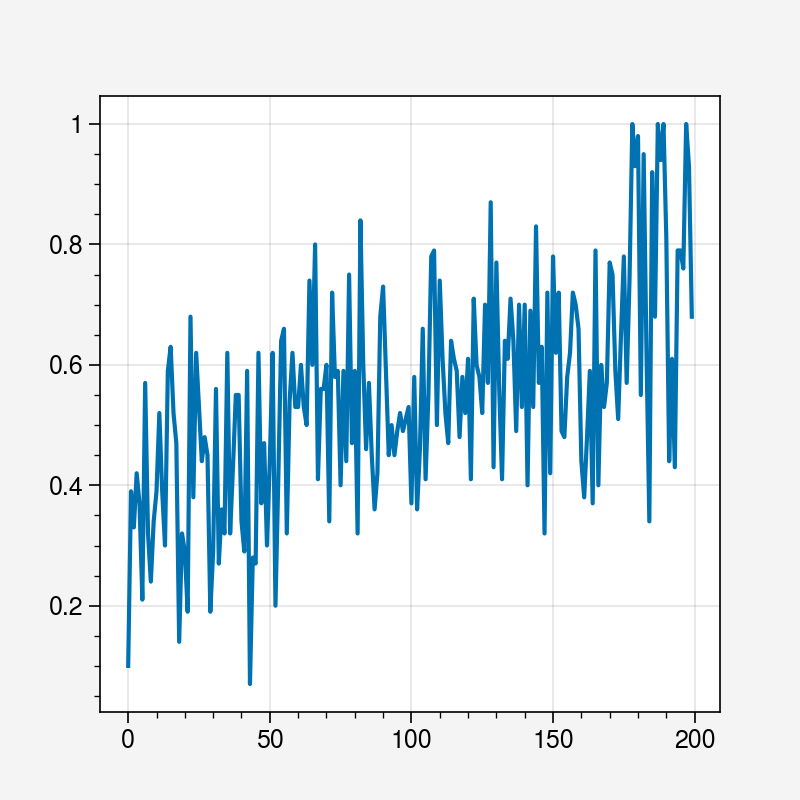

In [156]:
plt.plot(accuracies)

In [43]:
rollouts.rewards.sum()

tensor(0.)

In [240]:
cross_entropy_loss(auxiliary_preds[0], auxiliary_truth_batch[0].long().squeeze())

tensor(1.3857, grad_fn=<NllLossBackward0>)

In [239]:
auxiliary_truth_batch[0].long().squeeze()

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2])

In [177]:
populate_rollouts(model, envs, rollouts, num_steps)


In [176]:
model

Policy(
  (base): FlexBaseAux(
    (gru): GRU(24, 16)
    (critic0): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
    )
    (actor0): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
    )
    (critic1): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
    )
    (actor1): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
    )
    (critic_head): Linear(in_features=16, out_features=1, bias=True)
    (auxiliary0): Categorical(
      (linear): Linear(in_features=16, out_features=4, bias=True)
    )
    (auxiliary1): Categorical(
      (linear): Linear(in_features=16, out_features=2, bias=True)
    )
  )
  (dist): Categorical(
    (linear): Linear(in_features=16, out_features=4, bias=True)
  )
)

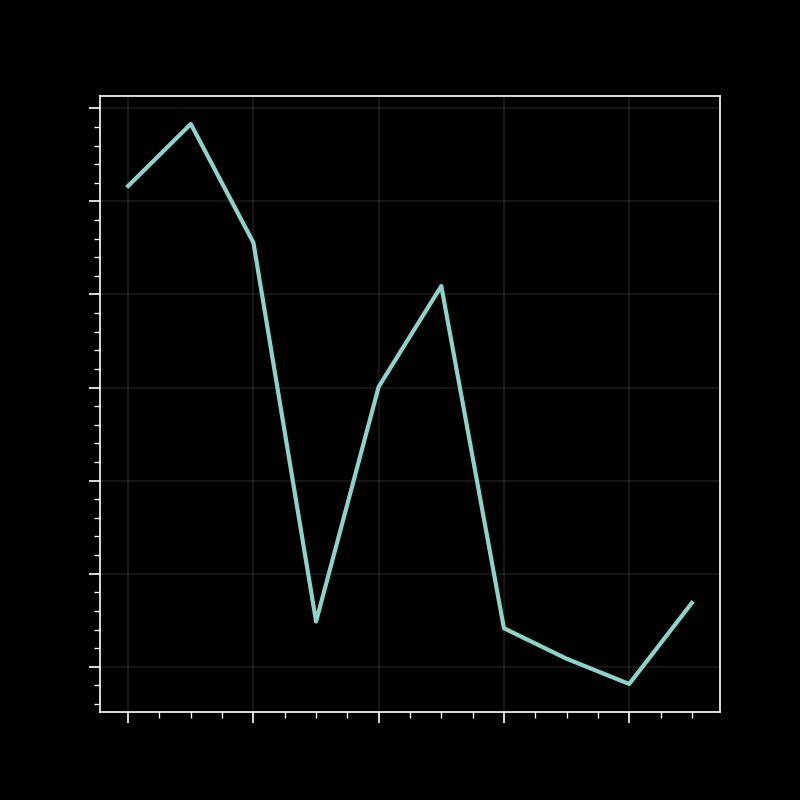

In [178]:
plt.plot(auxiliary_losses)

**Next Steps**
* Update main.py to use RolloutStorageAux (note that it needs auxiliary_pred_sizes and auxiliary_truth_sizes separately as args)
* Probably entirely migrate to using the new separated auxiliary methods for consistency and to remove the need to add additional args. However, do this by changing main.py code and gradients.py code to use the new Aux classes, to have the potential to continue running old trained models? Very annoying that we have to separate these out
* Add categorical auxiliary tasks to nav_env_flat, test the cross entropy losses with categorical distribution output
* Probably simply add auxiliary truth sizes as an argument 

In [1]:
import sys
sys.path.append('..')
from a2c_ppo_acktr.storage import RolloutStorageAux
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr import algo, utils
from  a2c_ppo_acktr.model import Policy
import torch
from collections import deque
%run ../a2c_ppo_acktr/model
%run ../a2c_ppo_acktr/storage
%run ../a2c_ppo_acktr/algo/ppo

'''
First 4 parameters are for shared recurrent layer. Can freeze these by setting
requires_grad = False
'''

def populate_rollouts_aux(model, envs, rollouts, num_steps):
    for step in range(num_steps):
        #Generate rollouts for num_steps batch
        with torch.no_grad():
            outputs = model.act(rollouts.obs[step], rollouts.recurrent_hidden_states[step],
                                rollouts.masks[step])
            action = outputs['action']
            value = outputs['value']
            action_log_prob = outputs['action_log_probs']
            recurrent_hidden_states = outputs['rnn_hxs']
            auxiliary_preds = outputs['auxiliary_preds']

        print(auxiliary_preds)
        obs, reward, done, infos = envs.step(action)
        
        auxiliary_truths = [[] for i in range(len(model.auxiliary_output_sizes))]
        for info in infos:
            if 'auxiliary' in info and len(info['auxiliary']) > 0:
                for i, aux in enumerate(info['auxiliary']):
                    auxiliary_truths[i].append(aux)
        if len(auxiliary_truths) > 0:
            auxiliary_truths = [torch.tensor(np.vstack(aux)) for aux in auxiliary_truths]
        
        print(auxiliary_truths)
        masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done])
        bad_masks = torch.FloatTensor([[0.0] if 'bad_transition' in info.keys() else [1.0] for info in infos])
        rollouts.insert(obs, recurrent_hidden_states, action, action_log_prob, value, reward, masks, bad_masks,
                       auxiliary_preds, auxiliary_truths)

        
def update_model(agent, rollouts, use_gae=False, gamma=0.99, gae_lambda=0.95,
                 after_update=True):
    
    #Compute last value to be used for the update
    with torch.no_grad():
        next_value = agent.actor_critic.get_value(rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                                            rollouts.masks[-1]).detach()
    
    rollouts.compute_returns(next_value, use_gae, gamma, gae_lambda)
    value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss = agent.update(rollouts)
    
    if after_update:
        rollouts.after_update()
        
    return value_loss, action_loss, dist_entropy, approx_kl, clipfracs, auxiliary_loss


def initialize_ppo_training(model=None, obs_rms=None, env_name='NavEnv-v0', env_kwargs={},
                            nn_base='FlexBaseAux', nn_base_kwargs={}, recurrent=True,
                            num_steps=10, num_processes=1, seed=0, ppo_epoch=4, clip_param=0.5,
                            num_mini_batch=1, value_loss_coef=0.5, entropy_coef=0.01, 
                            auxiliary_loss_coef=0.3, gamma=0.99, lr=7e-4, eps=1e-5, max_grad_norm=0.5,
                            log_dir='/tmp/gym/', device=torch.device('cpu'), 
                            capture_video=False, auxiliary_truth_sizes=[]):
    
    #Initialize vectorized environments
    envs = make_vec_envs(env_name, seed, num_processes, gamma, log_dir, device, False,
                         capture_video=capture_video, env_kwargs=env_kwargs)

    if model is None:
        model = Policy(envs.observation_space.shape,
                       envs.action_space,
                       base=nn_base,
                       base_kwargs={'recurrent': recurrent,
                           **nn_base_kwargs})
        model.to(device)
    
    #Wrap model with an agent algorithm object
    agent = PPOAux(model, clip_param, ppo_epoch, num_mini_batch,
                     value_loss_coef, entropy_coef, auxiliary_loss_coef, lr=lr,
                     eps=eps, max_grad_norm=max_grad_norm)


    #If loading a previously trained model, pass an obs_rms object to set the vec envs to use
    vec_norm = utils.get_vec_normalize(envs)
    if vec_norm is not None and obs_rms is not None:
        vec_norm.obs_rms = obs_rms


    #Double check if auxiliary_truth_sizes is given and same length
    if len(model.auxiliary_output_sizes) > 0:
        if len(model.auxiliary_output_sizes) != len(auxiliary_truth_sizes):
            raise Exception('auxiliary_output_sizes (from model) and auxiliary_truth_sizes are different lengths')
    #Initialize storage
    rollouts = RolloutStorageAux(num_steps, num_processes, envs.observation_space.shape, envs.action_space,
                              model.recurrent_hidden_state_size, model.auxiliary_output_sizes,
                              auxiliary_truth_sizes)
    #Storage objects initializes a bunch of empty tensors to store information, e.g.
    #obs has shape (num_steps+1, num_processes, obs_shape)
    #rewards has shape (num_steps, num_processes, 1)

    #obs, recurrent_hidden_states, value_preds, returns all have batch size num_steps+1
    #rewards, action_log_probs, actions, masks, auxiliary_preds, auxiliary_truths all have batch size num_steps
    obs = envs.reset()
    rollouts.obs[0].copy_(obs)
    rollouts.to(device)
    
    return agent, envs, rollouts

In [9]:
def initialize_ppo_training(model=None, obs_rms=None, env_name='NavEnv-v0', env_kwargs={},
                            nn_base='FlexBaseAux', nn_base_kwargs={}, recurrent=True,
                            num_steps=10, num_processes=1, seed=0, ppo_epoch=4, clip_param=0.5,
                            num_mini_batch=1, value_loss_coef=0.5, entropy_coef=0.01, 
                            auxiliary_loss_coef=0.3, gamma=0.99, lr=7e-4, eps=1e-5, max_grad_norm=0.5,
                            log_dir='/tmp/gym/', device=torch.device('cpu'), 
                            capture_video=False, auxiliary_truth_sizes=[]):
    
    #Initialize vectorized environments
    envs = make_vec_envs(env_name, seed, num_processes, gamma, log_dir, device, False,
                         capture_video=capture_video, env_kwargs=env_kwargs)

    if model is None:
        model = Policy(envs.observation_space.shape,
                       envs.action_space,
                       base=nn_base,
                       base_kwargs={'recurrent': recurrent,
                           **nn_base_kwargs})
        model.to(device)
    
    #Wrap model with an agent algorithm object
    agent = PPOAux(model, clip_param, ppo_epoch, num_mini_batch,
                     value_loss_coef, entropy_coef, auxiliary_loss_coef, lr=lr,
                     eps=eps, max_grad_norm=max_grad_norm)


    #If loading a previously trained model, pass an obs_rms object to set the vec envs to use
    vec_norm = utils.get_vec_normalize(envs)
    if vec_norm is not None and obs_rms is not None:
        vec_norm.obs_rms = obs_rms
        
    return agent, envs, None
        
agent, envs, rollouts = initialize_ppo_training(None, obs_rms=obs_rms, env_kwargs=env_kwargs, num_steps=num_steps, num_processes=num_processes,
# # agent, envs, rollouts = initialize_ppo_training(model, obs_rms=obs_rms, env_kwargs=env_kwargs, num_steps=num_steps, num_processes=num_processes,
#                                         #        auxiliary_truth_sizes=[1, 1, 1],
#                                         # nn_base_kwargs={'auxiliary_heads': [[-1, 0, 1, 4], [-1, 0, 1, 2], [-1, 0, 0, 1]], 'hidden_size':16})
#                                                auxiliary_truth_sizes=[1],
                                        # nn_base_kwargs={'auxiliary_heads': [[-1, 0, 1, 2], [-1, 0, 1, 2]], 'hidden_size':32}, auxiliary_truth_sizes=[1, 1])
                                        nn_base_kwargs={'auxiliary_heads': [], 'hidden_size':32}, auxiliary_truth_sizes=[])


In [13]:
agent.base.auxiliary_output_sizes

AttributeError: 'PPOAux' object has no attribute 'base'

In [19]:
agent.actor_critic.auxiliary_output_sizes

0

In [27]:
'''
Testing freezing params

We load a trained model, freeze the recurrent layer and train, showing that indeed parameters
besides the recurrent layer have updated
'''

from model_evaluation import load_model_and_env

model_name = 'nav_poster_netstructure/nav_pdistal_width64batch200'
model, obs_rms, env_kwargs = load_model_and_env(model_name, 0)

params = list(model.parameters())
temp_param_vals = []
for i in range(4):
    params[i].requires_grad=False
for i in range(len(params)):
    temp_param_vals.append(params[i].data.clone())
# list(model.parameters())[0].requires_grad=False



num_updates = 1 #total batch_size updates to do
num_steps = 10

agent, envs, rollouts = initialize_ppo_training(model, obs_rms, env_kwargs=env_kwargs)
for j in range(num_updates):
    populate_rollouts(model, envs, rollouts, num_steps)
    update_model(agent, rollouts)
    
for i in range(len(params)):
    print(temp_param_vals[i].squeeze()[0] - params[i].data.squeeze()[0]) 

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(0.)
tensor(0.)
tensor([ 0.0020, -0.0001,  0.0021, -0.0019, -0.0016, -0.0021, -0.0022,  0.0019,
         0.0021,  0.0023, -0.0017, -0.0019,  0.0021, -0.0025, -0.0020, -0.0021,
        -0.0022,  0.0023,  0.0022, -0.0021, -0.0022,  0.0022, -0.0020,  0.0019,
        -0.0021, -0.0021, -0.0019, -0.0023,  0.0024, -0.0020, -0.0025,  0.0023,
        -0.0021,  0.0019,  0.0023,  0.0023,  0.0022,  0.0025, -0.0024,  0.0020,
         0.0022, -0.0021,  0.0018,  0.0020,  0.0022, -0.0021,  0.0020, -0.0020,
         0.0018,  0.0023,  0.0021, -0.0019,  0.0016,  0.0023, -0.0018,  0.0020,
        -0.0017, -0.0018, -0.002

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

In [79]:
(auxiliary_preds[0] - auxiliary_truth_batch[0]).sum().backward()

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [2, 24]] is at version 17; expected version 16 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [47]:
# Reshape to do in a single forward pass for all steps
values, action_log_probs, dist_entropy, _, auxiliary_preds = agent.actor_critic.evaluate_actions(
    obs_batch, recurrent_hidden_states_batch, masks_batch,
    actions_batch)

logratio = action_log_probs - old_action_log_probs_batch 
ratio = torch.exp(logratio)
surr1 = ratio * adv_targ
surr2 = torch.clamp(ratio, 1.0 - agent.clip_param,
                    1.0 + agent.clip_param) * adv_targ
action_loss = -torch.min(surr1, surr2).mean()


if agent.use_clipped_value_loss:
    value_pred_clipped = value_preds_batch + \
        (values - value_preds_batch).clamp(-agent.clip_param, agent.clip_param)
    value_losses = (values - return_batch).pow(2)
    value_losses_clipped = (
        value_pred_clipped - return_batch).pow(2)
    value_loss = 0.5 * torch.max(value_losses,
                                 value_losses_clipped).mean()
else:
    value_loss = 0.5 * (return_batch - values).pow(2).mean()
    
    
auxiliary_losses = torch.zeros(len(agent.auxiliary_types))
for i, aux_type in enumerate(agent.auxiliary_types):
    if aux_type == 0:
        auxiliary_losses[i] = 0.5 * (auxiliary_truth_batch[i] - auxiliary_preds[i]).pow(2).mean()
    elif aux_type == 1:
        auxiliary_losses[i] = agent.cross_entropy_loss(auxiliary_preds[i], auxiliary_truth_batch[i])


In [48]:
auxiliary_losses.sum()

tensor(0.2742, grad_fn=<SumBackward0>)

In [50]:
print(value_loss.grad_fn, action_loss.grad_fn, auxiliary_loss.grad_fn, dist_entropy.grad_fn)


<MulBackward0 object at 0x0000024A10CFFC40> <NegBackward0 object at 0x0000024A10CFFBB0> <AddBackward0 object at 0x0000024A10DF2D30> <MeanBackward0 object at 0x0000024A10DF2940>


In [51]:
losses = value_loss * agent.value_loss_coef + action_loss + \
                 auxiliary_losses.sum() * agent.auxiliary_loss_coef - \
                 dist_entropy * agent.entropy_coef

In [52]:
losses.backward()

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [2, 24]] is at version 17; expected version 16 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

tensor(0.)

In [267]:
auxiliary_loss = torch.zeros(1)

In [274]:
print((auxiliary_truth_batch[0] - auxiliary_preds[0]).pow(2).mean())

tensor(0.4800, grad_fn=<MeanBackward0>)


In [236]:
auxiliary_preds[0].shape

torch.Size([32, 1])

In [244]:
auxiliary_pred_batch = [[] for i in range(len(rollouts.auxiliary_preds))]
for j in range(2):
    for i, pred in enumerate(rollouts.auxiliary_preds):
        auxiliary_pred_batch[i].append(pred[:, j])
auxiliary_pred_batch = [torch.stack(pred, 1) for pred in auxiliary_pred_batch]

In [247]:
auxiliary_pred_batch[0].shape

torch.Size([16, 2, 1])

In [255]:
for i, pred in enumerate(auxiliary_pred_batch):
    auxiliary_pred_batch[i] = _flatten_helper(16, 2, auxiliary_pred_batch[0])

In [256]:
auxiliary_pred_batch[0].shape

torch.Size([32, 1])

In [238]:
auxiliary_truth_batch[0].shape

torch.Size([16, 2, 1])

In [156]:
actor_critic.recurrent_hidden_state_size

16

In [158]:
rollouts.recurrent_hidden_states.shape

torch.Size([17, 2, 16])

In [127]:
(auxiliary_pred_batch[0] - auxiliary_truth_batch[0]).pow(2).mean()

tensor(0.5645, grad_fn=<MeanBackward0>)

In [133]:
values, action_log_probs, dist_entropy, _, auxiliary_preds = actor_critic.evaluate_actions(
                    obs_batch, recurrent_hidden_states_batch, masks_batch,
                    actions_batch)

In [140]:
auxiliary_truth_batch[0].view(-1, 1).shape

torch.Size([32, 1])

In [137]:
auxiliary_truth_batch[0].shape

torch.Size([16, 2, 1])

In [138]:
auxiliary_preds[0].shape

torch.Size([32, 1])

## Old code for comparison

In [80]:
exp_name = 'nav_pdistal_batchaux/nav_pdistal_batch32auxwall01'
# exp_name = 'nav_pdistal_batchaux/nav_pdistal_batch32auxwall0'
_, _, env_kwargs = load_model_and_env(exp_name, 0)
# env_kwargs['separate_aux_tasks'] = True

num_steps = 16
num_envs = 2


envs = make_vec_envs('NavEnv-v0', 0, num_envs, 0.99, '/tmp/gym/_eval/', torch.device('cpu'), True,
                    capture_video=False, env_kwargs=env_kwargs)


# base = FlexBaseAux(num_inputs=envs.observation_space.shape[0], hidden_size=16, auxiliary_heads=[[-1, 0, 1, 4]])
# base = FlexBase(num_inputs=envs.observation_space.shape[0], hidden_size=16, auxiliary_heads=[[-1, 0, 1]])

actor_critic = Policy(envs.observation_space.shape, envs.action_space, base='FlexBase',
      base_kwargs={'auxiliary_heads': [[-1, 0, 1], [-1, 0, 1]], 'hidden_size':16})
# actor_critic = Policy(envs.observation_space.shape, envs.action_space, base='FlexBase',
#       base_kwargs={'auxiliary_heads': [[-1, 0, 1]], 'hidden_size':16})

# rollouts = RolloutStorageAux(num_steps, num_envs,
#                           envs.observation_space.shape, envs.action_space,
#                           actor_critic.recurrent_hidden_state_size,
#                           actor_critic.auxiliary_output_sizes, auxiliary_truth_sizes=[1, 1])
agent = PPO(actor_critic, 0.2, 1, 1, 0.5, 0.01, 0.5, lr=7e-4, eps=1e-5, max_grad_norm=0.5)
rollouts = RolloutStorage(num_steps, num_envs,
                          envs.observation_space.shape, envs.action_space,
                          actor_critic.recurrent_hidden_state_size,
                          actor_critic.auxiliary_output_size)


obs = envs.reset()
rollouts.obs[0] = obs



for step in range(num_steps):
    outputs = actor_critic.act(rollouts.obs[step], rollouts.recurrent_hidden_states[step],
        rollouts.masks[step])
    action = outputs['action']

    obs, reward, done, infos = envs.step(action)

    value = outputs['value']
    action_log_prob = outputs['action_log_probs']
    recurrent_hidden_states = outputs['rnn_hxs']
    auxiliary_preds = outputs['auxiliary_preds']
    masks = torch.FloatTensor(
        [[0.0] if done_ else [1.0] for done_ in done])
    bad_masks = torch.FloatTensor(
        [[0.0] if 'bad_transition' in info.keys() else [1.0]
         for info in infos])



    auxiliary_truths = []
    for info in infos:
        if 'auxiliary' in info:
            if len(info['auxiliary'] > 0):
                auxiliary_truths.append(info['auxiliary'])
    if len(auxiliary_truths) > 0:
        auxiliary_truths = torch.tensor(np.vstack(auxiliary_truths))
    else:
        auxiliary_truths = None

    rollouts.insert(obs, recurrent_hidden_states, action,
                    action_log_prob, value, reward, masks, bad_masks,
                    auxiliary_preds, auxiliary_truths)



In [81]:
advantages = rollouts.returns[:-1] - rollouts.value_preds[:-1]
advantages = (advantages - advantages.mean()) / (
    advantages.std() + 1e-5)

data_generator = rollouts.recurrent_generator(
    advantages, 1)


for sample in data_generator:
    break

obs_batch, recurrent_hidden_states_batch, actions_batch, \
                   value_preds_batch, return_batch, masks_batch, old_action_log_probs_batch, \
                    adv_targ, auxiliary_pred_batch, auxiliary_truth_batch = sample

values, action_log_probs, dist_entropy, _, auxiliary_preds = actor_critic.evaluate_actions(
                    obs_batch, recurrent_hidden_states_batch, masks_batch,
                    actions_batch)

In [85]:
(auxiliary_preds - auxiliary_truth_batch).sum().backward()

C:\Users\14and\anaconda3\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "C:\Users\14and\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\14and\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\14and\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\14and\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\14and\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
    self.io_loop.start()
  File "C:\Users\14and\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\14and\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
    

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [2, 24]] is at version 17; expected version 16 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [231]:
auxiliary_preds.shape

torch.Size([32, 2])

In [218]:
auxiliary_pred_batch.shape

torch.Size([32, 1])

In [219]:
auxiliary_pred_batch = []
for i in range(2):
    auxiliary_pred_batch.append(rollouts.auxiliary_preds[:, 0])

In [225]:
_flatten_helper(16, 2, torch.stack(auxiliary_pred_batch, 1)).shape

torch.Size([32, 2])

In [186]:
auxiliary_truths

tensor([[0.9218, 0.5782],
        [0.3185, 0.1815]], dtype=torch.float64)

In [188]:
rollouts.auxiliary_truths.shape

torch.Size([16, 2, 2])

# Run episodes

In [110]:
%run model_evaluation
%run representation_analysis

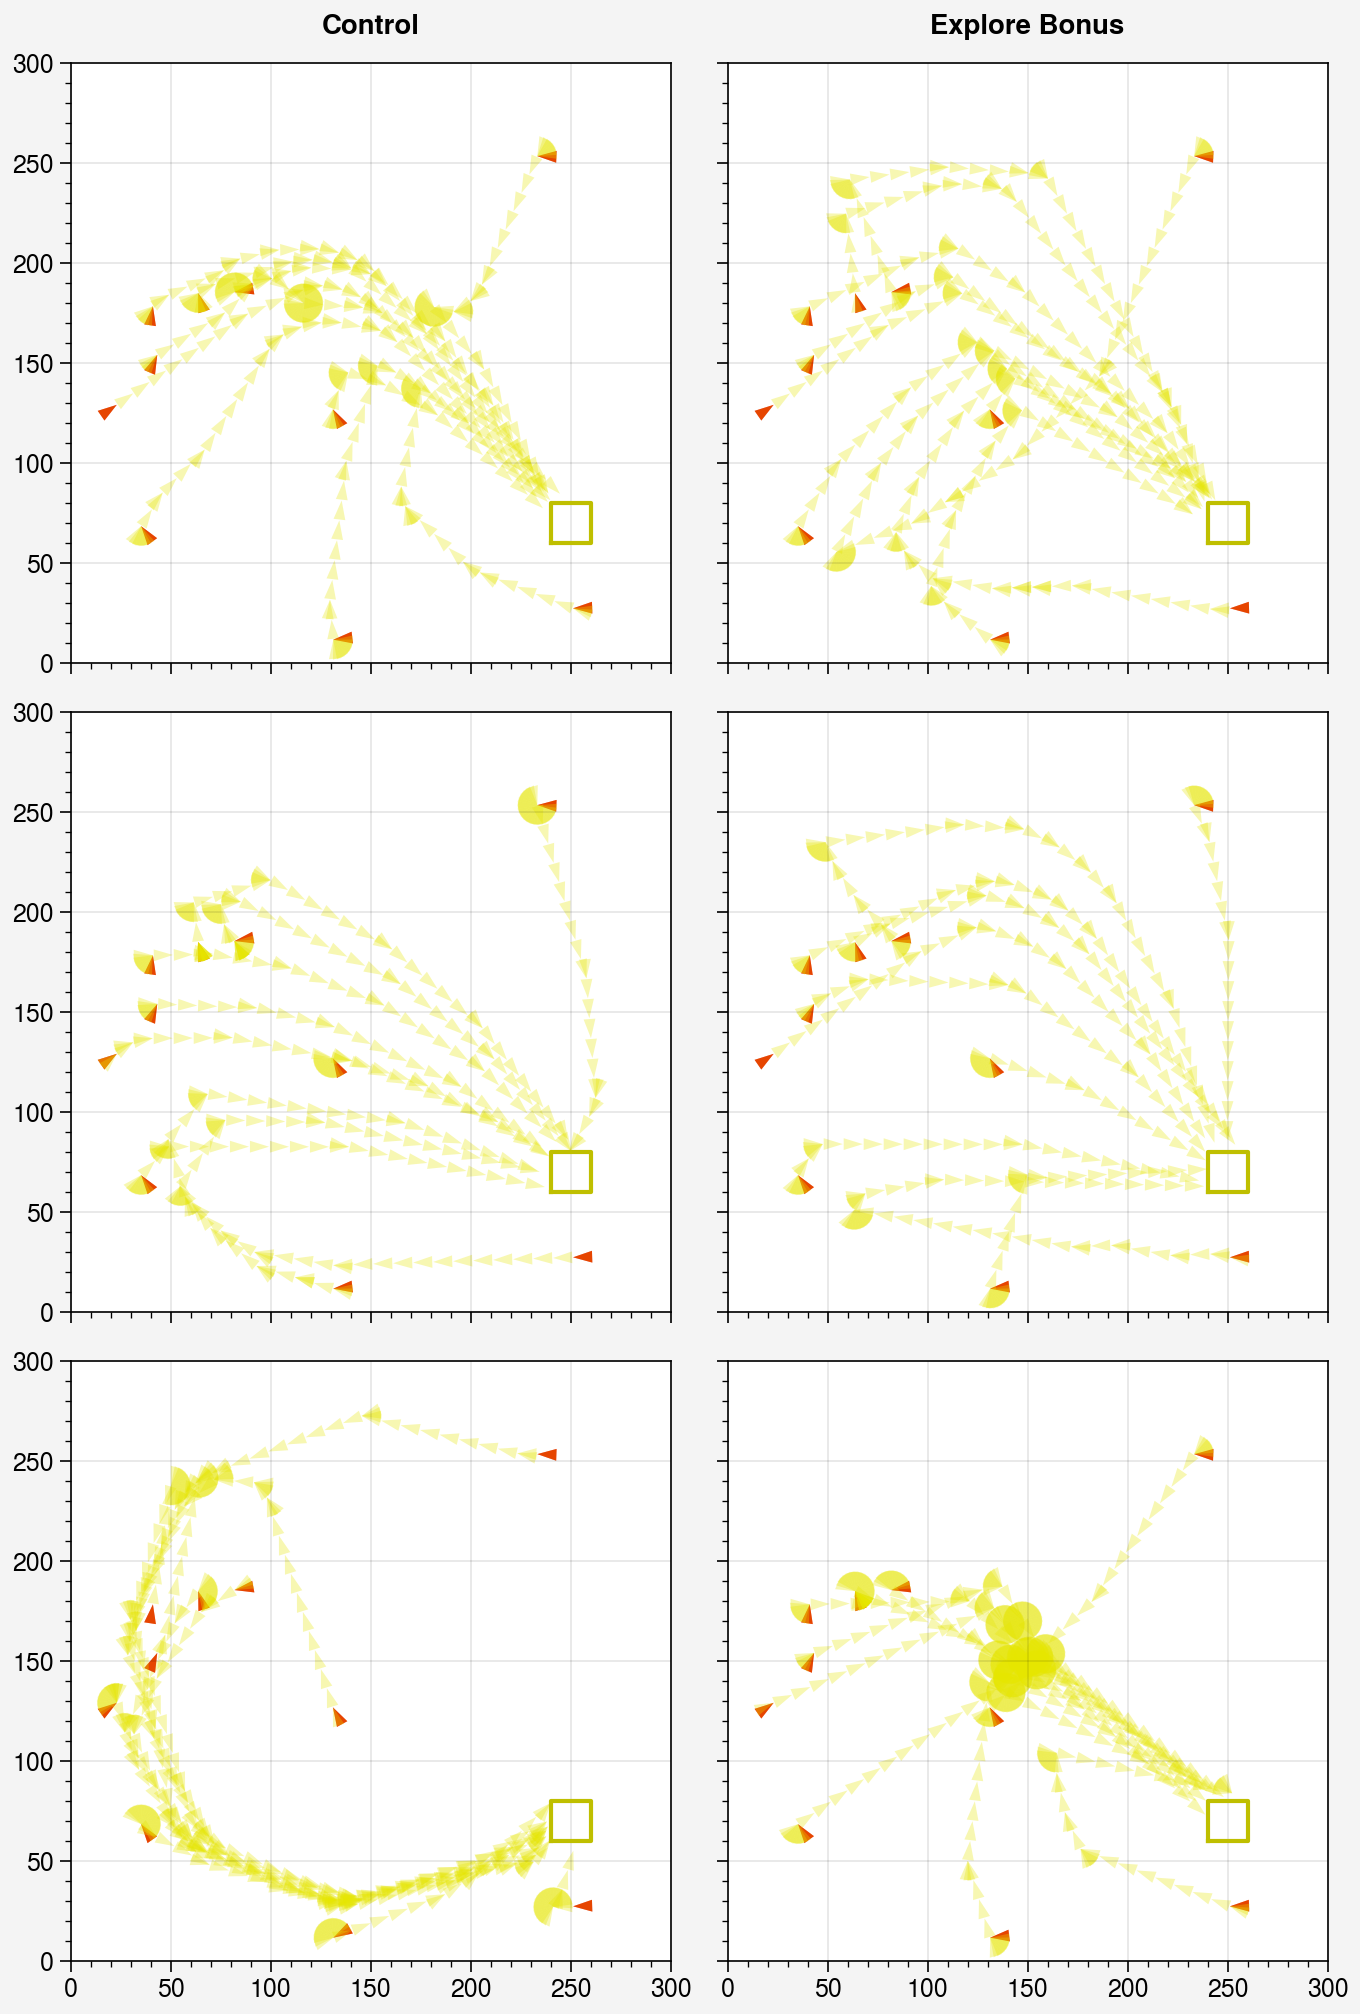

In [87]:
aux_tasks = ['none', 'rewexplore']
aux_task_labels = ['Control', 'Explore Bonus']
batch = 16

ncols = 2
nrows = 3

fig, axs = pplt.subplots(ncols=ncols, nrows=nrows, refwidth=3)
axs.format(xlim=(0, 300), ylim=(0, 300), toplabels=aux_task_labels)

ress = []

# for n, ax in enumerate(ax):

for x in range(nrows):
    for y in range(ncols):
        aux = aux_tasks[y]
        ax = axs[x, y]
    
        exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
        model, obs_rms, kwargs = load_model_and_env(exp_name, x)

        res = evalu(model, obs_rms, n=10, data_callback=poster_data_callback, env_kwargs=kwargs)
        ress.append(res)

        ep_pos = split_by_ep(np.vstack(res['data']['pos']), res['dones'])
        ep_angle = split_by_ep(np.vstack(res['data']['angle']), res['dones'])
        draw_box(ax=ax)
        for pos, angles in zip(ep_pos, ep_angle):
            for i, (p, a) in enumerate(zip(pos, angles)):
                if i == 0:
                    draw_character(p, a, ax=ax, draw_color=[0.9, 0, 0, 1])
                draw_character(p, a, ax=ax)

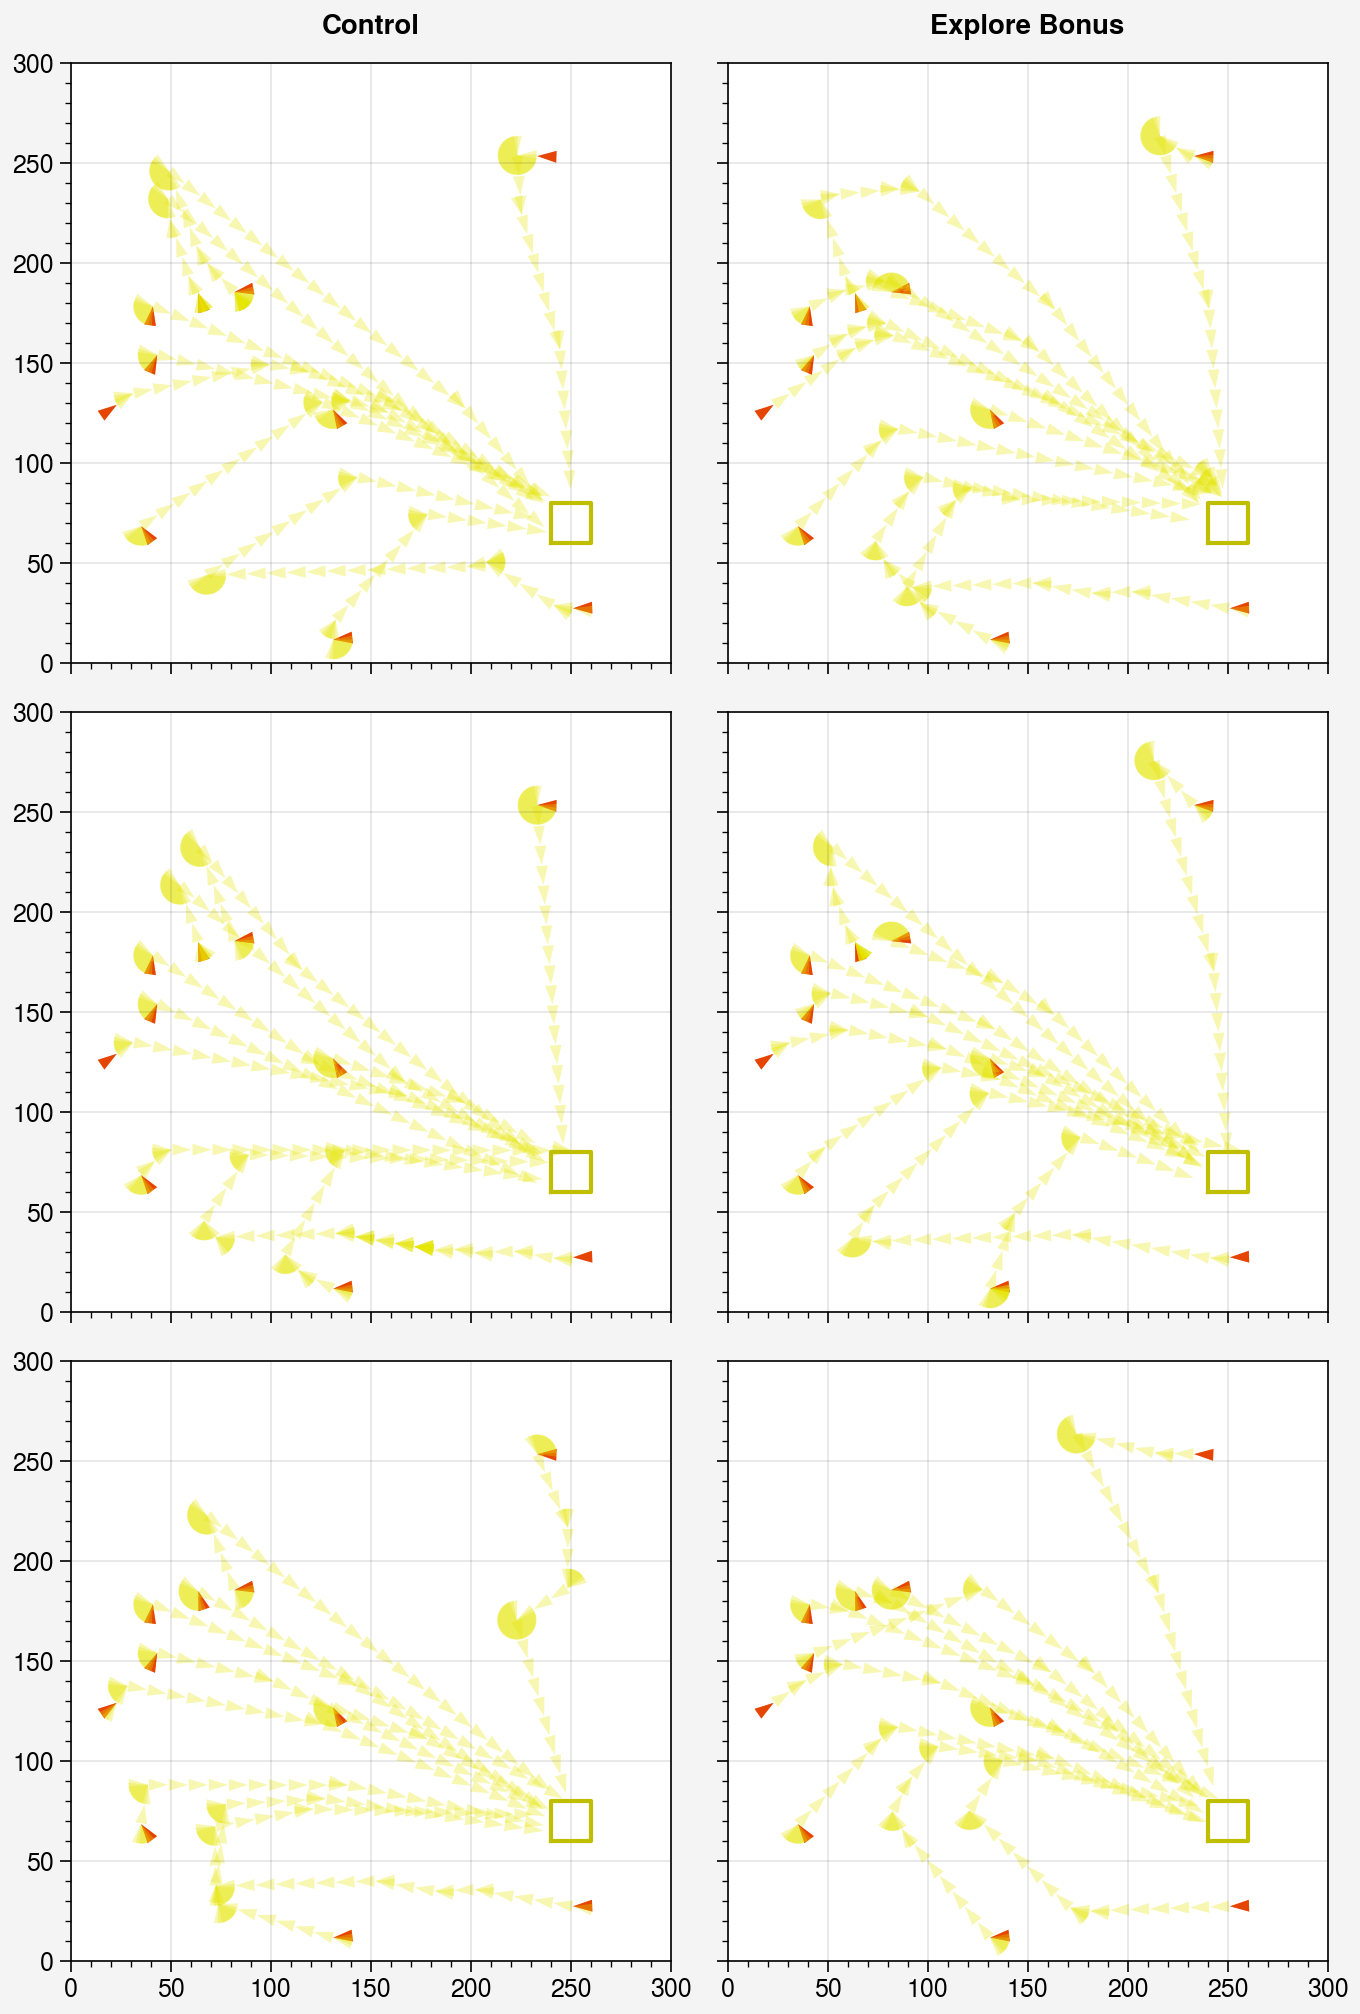

In [88]:
aux_tasks = ['none', 'rewexplore']
aux_task_labels = ['Control', 'Explore Bonus']
batch = 32

ncols = 2
nrows = 3

fig, axs = pplt.subplots(ncols=ncols, nrows=nrows, refwidth=3)
axs.format(xlim=(0, 300), ylim=(0, 300), toplabels=aux_task_labels)

ress = []

# for n, ax in enumerate(ax):

for x in range(nrows):
    for y in range(ncols):
        aux = aux_tasks[y]
        ax = axs[x, y]
    
        exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
        model, obs_rms, kwargs = load_model_and_env(exp_name, x)

        res = evalu(model, obs_rms, n=10, data_callback=poster_data_callback, env_kwargs=kwargs)
        ress.append(res)

        ep_pos = split_by_ep(np.vstack(res['data']['pos']), res['dones'])
        ep_angle = split_by_ep(np.vstack(res['data']['angle']), res['dones'])
        draw_box(ax=ax)
        for pos, angles in zip(ep_pos, ep_angle):
            for i, (p, a) in enumerate(zip(pos, angles)):
                if i == 0:
                    draw_character(p, a, ax=ax, draw_color=[0.9, 0, 0, 1])
                draw_character(p, a, ax=ax)

C:\Users\14and\anaconda3\lib\site-packages\matplotlib\patches.py:1117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


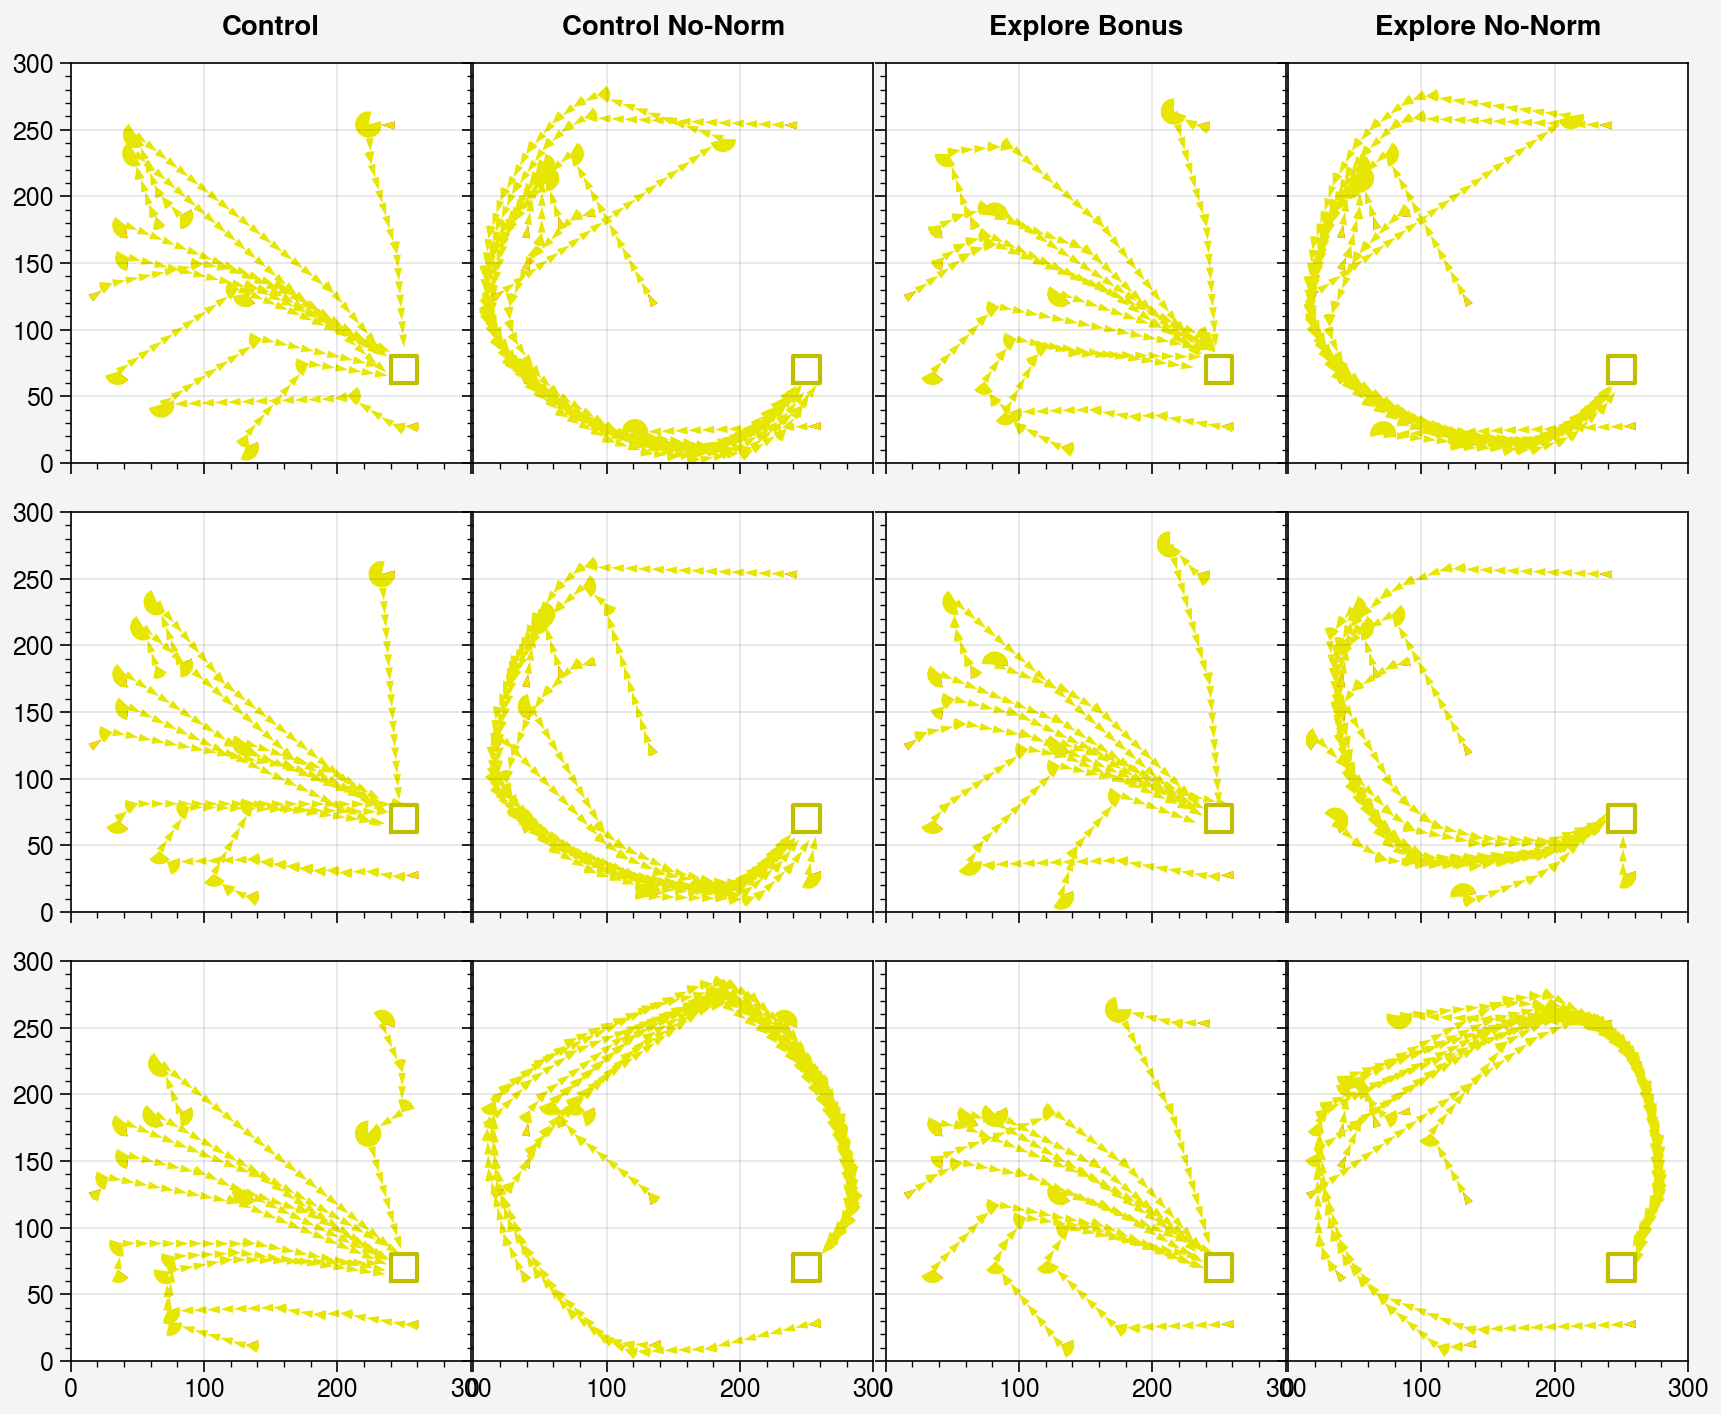

In [3]:
aux_tasks = ['none', 'nonenonorm','rewexplore', 'rewexplorenonorm']
aux_task_labels = ['Control', 'Control No-Norm', 'Explore Bonus', 'Explore No-Norm']
batch = 32

ncols = 4
nrows = 3

fig, axs = pplt.subplots(ncols=ncols, nrows=nrows, refwidth=2,
                        wspace=[0.1, 0.5, 0.1])
axs.format(xlim=(0, 300), ylim=(0, 300), toplabels=aux_task_labels)

ress = []

# for n, ax in enumerate(ax):

for x in range(nrows):
    for y in range(ncols):
        aux = aux_tasks[y]
        ax = axs[x, y]
        
        if y % 2 == 1:
            normalize = False
        else:
            normalize = True
        exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
        model, obs_rms, kwargs = load_model_and_env(exp_name, x)

        res = evalu(model, obs_rms, n=10, data_callback=poster_data_callback, env_kwargs=kwargs,
                   normalize=normalize)
        ress.append(res)

        ep_pos = split_by_ep(np.vstack(res['data']['pos']), res['dones'])
        ep_angle = split_by_ep(np.vstack(res['data']['angle']), res['dones'])
        draw_box(ax=ax)
        for pos, angles in zip(ep_pos, ep_angle):
            for i, (p, a) in enumerate(zip(pos, angles)):
                if i == 0:
                    draw_character(p, a, ax=ax, color=[0.9, 0, 0, 1])
                draw_character(p, a, ax=ax)

# Test auxiliary outputs on trained models

In [7]:
obs_rms

In [12]:
%run gradients
%run model_evaluation
exp_name = 'nav_pdistal_batchaux/nav_pdistal_batch32auxwall01'
model, obs_rms, env_kwargs = load_model_and_env(exp_name, 0)
agent, envs, storage = initialize_ppo_training(model, obs_rms, env_kwargs=env_kwargs,
                                   num_steps=128, agent_base='LoudPPO', num_processes=1, 
                                   ppo_epoch=1, take_optimizer_step=False, new_aux=False)
data, info = populate_rollouts(model, envs, storage)

In [19]:
wall0_truths = []
wall0_preds = []
wall1_truths = []
wall1_preds = []

wall0_truths += storage.auxiliary_truths[:, 0, 0].tolist()
wall1_truths += storage.auxiliary_truths[:, 0, 1].tolist()
wall0_preds += storage.auxiliary_preds[:, 0, 0].tolist()
wall1_preds += storage.auxiliary_preds[:, 0, 1].tolist()

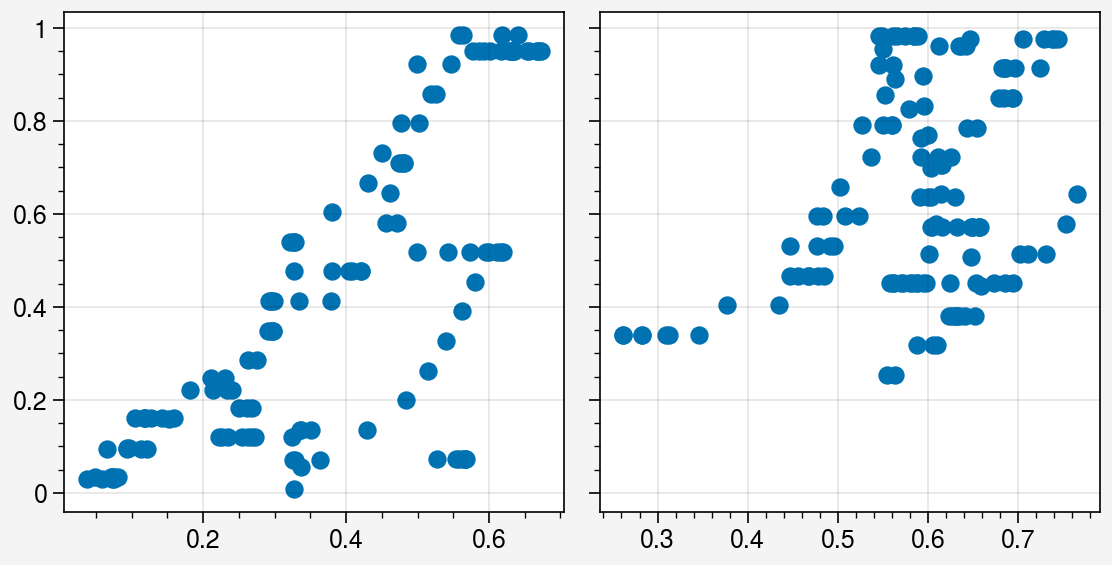

In [21]:
fig, ax = pplt.subplots(ncols=2)
ax[0].scatter(wall0_preds, wall0_truths)
ax[1].scatter(wall1_preds, wall1_truths)

In [29]:
%run gradients
%run model_evaluation
exp_name = 'nav_pdistal_batchaux/nav_pdistal_batch32auxterminal'
model, obs_rms, env_kwargs = load_model_and_env(exp_name, 0)
agent, envs, storage = initialize_ppo_training(model, obs_rms, env_kwargs=env_kwargs,
                                   num_steps=128, agent_base='LoudPPO', num_processes=1, 
                                   ppo_epoch=1, take_optimizer_step=False, new_aux=False)
data, info = populate_rollouts(model, envs, storage)

In [33]:
wall0_truths = []
wall0_preds = []
wall1_truths = []
wall1_preds = []

wall0_truths += storage.auxiliary_truths[:, 0].tolist()
# wall1_truths += storage.auxiliary_truths[:, 0].tolist()
wall0_preds += storage.auxiliary_preds[:, 0].tolist()
# wall1_preds += storage.auxiliary_preds[:, 0, 1].tolist()

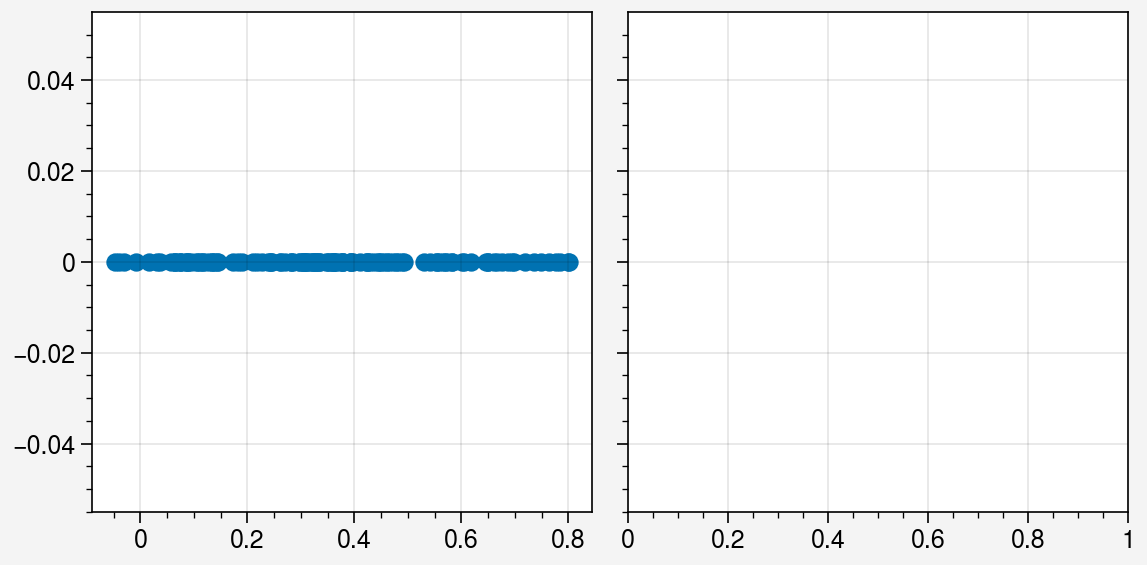

In [34]:
fig, ax = pplt.subplots(ncols=2)
ax[0].scatter(wall0_preds, wall0_truths)
# ax[1].scatter(wall1_preds, wall1_truths)

In [25]:
envs

a2c_ppo_acktr.algo.ppo.PPO